In [2]:
#!/usr/bin/env python
# coding: utf-8

# ===============================
# 📚 IMPORT THƯ VIỆN
# ===============================
from sqlalchemy import create_engine
import pandas as pd
import urllib.parse
import numpy as np
import pyodbc
import pyarrow as pa 
import os, gc, re 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from fastparquet import write
import pyarrow.parquet as pq
warnings.filterwarnings('ignore')

print("✅ Đã import tất cả thư viện cần thiết")

✅ Đã import tất cả thư viện cần thiết


In [29]:
# ===============================
# 🔧 CẤU HÌNH KẾT NỐI DATABASE - FIXED
# ===============================
server = r"KINAS2K4\SQLEXPRESS"  
database = "MiniRecommendation"     
table = "CustomerOrderSummary"     
driver = "ODBC Driver 17 for SQL Server"     

# Tạo connection string - FIXED định dạng
try:
    params = urllib.parse.quote_plus(
        f"DRIVER={{{driver}}};"
        f"SERVER={server};"
        f"DATABASE={database};"
        "Trusted_Connection=yes;"
    )
    connection_url = f"mssql+pyodbc:///?odbc_connect={params}"
    print("🔧 Đã cấu hình kết nối database")
except Exception as e:
    print(f"❌ Lỗi cấu hình kết nối: {e}")
    exit()

🔧 Đã cấu hình kết nối database


In [30]:
# ===============================
# 🔌 KẾT NỐI DATABASE - ADVANCED VERSION WITH DETAILED INFO - FIXED
# ===============================
from sqlalchemy import text, exc, inspect

def get_detailed_database_info(connection_url, table_name=None):
    """Lấy thông tin chi tiết về database và table - FIXED Styler Error"""
    
    print("🔍 ĐANG LẤY THÔNG TIN CHI TIẾT DATABASE...")
    
    try:
        # Tạo engine
        engine = create_engine(connection_url, fast_executemany=True)
        
        with engine.connect() as conn:
            # Test kết nối cơ bản
            result = conn.execute(text("SELECT 1 AS test_value, @@VERSION as sql_version"))
            test_row = result.fetchone()
            
            if test_row[0] == 1:
                print("✅ Kết nối SQL Server thành công!")
                print(f"🔧 Phiên bản SQL Server: {test_row[1].split('\n')[0]}")
                
                if table_name:
                    print(f"\n📁 ĐANG PHÂN TÍCH TABLE: {table_name}")
                    print("=" * 100)
                    
                    # 1. Thông tin cơ bản về table
                    try:
                        # Lấy schema và tên database
                        schema_query = text(f"""
                            SELECT 
                                TABLE_SCHEMA,
                                TABLE_CATALOG
                            FROM INFORMATION_SCHEMA.TABLES 
                            WHERE TABLE_NAME = '{table_name}'
                        """)
                        schema_result = conn.execute(schema_query)
                        schema_info = schema_result.fetchone()
                        
                        if schema_info:
                            schema_name, database_name = schema_info
                            print(f"📂 Database: {database_name}")
                            print(f"📂 Schema: {schema_name}")
                            print(f"📄 Table: {table_name}")
                    except Exception as schema_error:
                        print(f"⚠️ Không thể lấy thông tin schema: {schema_error}")
                    
                    # 2. Chi tiết các cột
                    print(f"\n📋 CHI TIẾT CÁC CỘT:")
                    print("-" * 100)
                    
                    detailed_column_query = text(f"""
                        SELECT 
                            COLUMN_NAME as 'Tên Cột',
                            DATA_TYPE as 'Kiểu Dữ Liệu',
                            IS_NULLABLE as 'Cho phép NULL',
                            CASE 
                                WHEN CHARACTER_MAXIMUM_LENGTH IS NOT NULL THEN 
                                    CAST(CHARACTER_MAXIMUM_LENGTH AS VARCHAR) + ' chars'
                                WHEN NUMERIC_PRECISION IS NOT NULL THEN 
                                    CAST(NUMERIC_PRECISION AS VARCHAR) + 
                                    CASE WHEN NUMERIC_SCALE > 0 THEN ',' + CAST(NUMERIC_SCALE AS VARCHAR) ELSE '' END
                                ELSE 'N/A'
                            END as 'Kích thước/Độ chính xác',
                            COLUMN_DEFAULT as 'Giá trị mặc định'
                        FROM INFORMATION_SCHEMA.COLUMNS 
                        WHERE TABLE_NAME = '{table_name}'
                        ORDER BY ORDINAL_POSITION
                    """)
                    
                    column_result = conn.execute(detailed_column_query)
                    columns_info = column_result.fetchall()
                    
                    if columns_info:
                        # Tạo DataFrame để hiển thị
                        columns_df = pd.DataFrame(columns_info, 
                                                columns=['Tên Cột', 'Kiểu Dữ Liệu', 'Cho phép NULL', 
                                                        'Kích thước/Độ chính xác', 'Giá trị mặc định'])
                        
                        # ĐẢM BẢO INDEX UNIQUE - FIXED
                        columns_df = columns_df.reset_index(drop=True)
                        
                        # Hiển thị với định dạng đẹp
                        pd.set_option('display.max_rows', None)
                        pd.set_option('display.max_columns', None)
                        pd.set_option('display.width', 1000)
                        pd.set_option('display.colheader_justify', 'left')
                        
                        display(columns_df)
                        
                        # Thống kê
                        print(f"\n📊 THỐNG KÊ TABLE:")
                        print(f"   • Tổng số cột: {len(columns_df)}")
                        print(f"   • Cột cho phép NULL: {len(columns_df[columns_df['Cho phép NULL'] == 'YES'])}")
                        print(f"   • Cột NOT NULL: {len(columns_df[columns_df['Cho phép NULL'] == 'NO'])}")
                        
                        # Thống kê kiểu dữ liệu
                        type_summary = columns_df.groupby('Kiểu Dữ Liệu').size()
                        print(f"\n📈 PHÂN BỐ KIỂU DỮ LIỆU:")
                        for dtype, count in type_summary.items():
                            percentage = (count / len(columns_df)) * 100
                            print(f"   • {dtype}: {count} cột ({percentage:.1f}%)")
                    
                    # 3. Thông tin indexes (nếu có)
                    try:
                        print(f"\n🔍 THÔNG TIN INDEXES:")
                        index_query = text(f"""
                            SELECT 
                                i.name as index_name,
                                i.type_desc as index_type,
                                i.is_unique as is_unique,
                                COUNT(ic.column_id) as column_count
                            FROM sys.indexes i
                            INNER JOIN sys.index_columns ic ON i.object_id = ic.object_id AND i.index_id = ic.index_id
                            WHERE i.object_id = OBJECT_ID('{table_name}') AND i.name IS NOT NULL
                            GROUP BY i.name, i.type_desc, i.is_unique
                            ORDER BY i.name
                        """)
                        
                        index_result = conn.execute(index_query)
                        indexes_info = index_result.fetchall()
                        
                        if indexes_info:
                            indexes_df = pd.DataFrame(indexes_info, 
                                                    columns=['Tên Index', 'Loại Index', 'Unique', 'Số cột'])
                            
                            # ĐẢM BẢO INDEX UNIQUE - FIXED
                            indexes_df = indexes_df.reset_index(drop=True)
                            
                            display(indexes_df)
                        else:
                            print("   • Không có indexes được định nghĩa")
                    except Exception as index_error:
                        print(f"   ⚠️ Không thể lấy thông tin indexes: {index_error}")
                    
                    # 4. Dữ liệu mẫu - FIXED STYLER ERROR
                    print(f"\n👀 DỮ LIỆU MẪU (10 dòng đầu):")
                    sample_query = text(f"SELECT TOP 10 * FROM {table_name}")
                    sample_result = conn.execute(sample_query)
                    sample_data = sample_result.fetchall()
                    
                    if sample_data:
                        column_names = [col[0] for col in sample_result.keys()]
                        sample_df = pd.DataFrame(sample_data, columns=column_names)
                        
                        # FIXED: Đảm bảo index và columns unique trước khi dùng Styler
                        sample_df = sample_df.reset_index(drop=True)
                        sample_df.columns = [f"{col}_{i}" if sample_df.columns.duplicated().any() else col 
                                           for i, col in enumerate(sample_df.columns)]
                        
                        try:
                            # Thử sử dụng Styler với error handling
                            styled_sample = sample_df.style.set_properties(**{
                                'background-color': '#f8f9fa',
                                'color': 'black',
                                'border-color': 'white',
                                'font-size': '12px'
                            }).set_table_styles([{
                                'selector': 'th',
                                'props': [('background-color', '#007bff'), 
                                        ('color', 'white'),
                                        ('font-weight', 'bold'),
                                        ('font-size', '12px')]
                            }])
                            
                            display(styled_sample)
                            
                        except Exception as style_error:
                            print(f"⚠️ Không thể áp dụng style, hiển thị bình thường: {style_error}")
                            display(sample_df)
                        
                        print(f"📝 Mô tả dữ liệu mẫu:")
                        print(f"   • Số dòng hiển thị: {len(sample_df)}")
                        print(f"   • Số cột hiển thị: {len(sample_df.columns)}")
                        
                        # Hiển thị thông tin thêm về dữ liệu
                        print(f"\n📊 THÔNG TIN THÊM VỀ DỮ LIỆU:")
                        
                        # Kiểm tra các kiểu dữ liệu trong sample
                        print(f"   • Kiểu dữ liệu trong sample:")
                        for col in sample_df.columns[:5]:  # Chỉ hiển thị 5 cột đầu
                            dtype = sample_df[col].dtype
                            non_null_count = sample_df[col].notna().sum()
                            print(f"     - {col}: {dtype} ({non_null_count}/{len(sample_df)} non-null)")
                        
                    else:
                        print("   • Table không có dữ liệu")
                        
                return engine
            else:
                print("❌ Kết nối test không thành công")
                return None
                
    except Exception as e:
        print(f"❌ Lỗi kết nối: {e}")
        return None

# Sử dụng hàm nâng cao đã fix
print("🎯 BẮT ĐẦU KIỂM TRA KẾT NỐI VÀ PHÂN TÍCH DATABASE CHI TIẾT...")
engine = get_detailed_database_info(connection_url, table)

if engine is None:
    print("❌ Không thể kết nối database, dừng chương trình...")
    exit()
else:
    print("\n🎯 PHÂN TÍCH HOÀN TẤT! TIẾP TỤC CHƯƠNG TRÌNH...")

🎯 BẮT ĐẦU KIỂM TRA KẾT NỐI VÀ PHÂN TÍCH DATABASE CHI TIẾT...
🔍 ĐANG LẤY THÔNG TIN CHI TIẾT DATABASE...
✅ Kết nối SQL Server thành công!
🔧 Phiên bản SQL Server: Microsoft SQL Server 2022 (RTM-GDR) (KB5065221) - 16.0.1150.1 (X64) 

📁 ĐANG PHÂN TÍCH TABLE: CustomerOrderSummary
📂 Database: MiniRecommendation
📂 Schema: dbo
📄 Table: CustomerOrderSummary

📋 CHI TIẾT CÁC CỘT:
----------------------------------------------------------------------------------------------------


,Tên Cột,Kiểu Dữ Liệu,Cho phép NULL,Kích thước/Độ chính xác,Giá trị mặc định
0,OrderGroupId,int,NO,10,None
1,CustomerId,uniqueidentifier,NO,N/A,None
2,CustomerName,nvarchar,YES,64 chars,None
3,OrderTotal,decimal,NO,"38,9",None
4,SubTotal,decimal,NO,"38,9",None
5,ShippingTotal,decimal,NO,"38,9",None
6,TaxTotal,decimal,NO,"38,9",None
7,BillingCurrency,nvarchar,YES,64 chars,None
8,OrderStatus,nvarchar,YES,64 chars,None
9,MarketId,nvarchar,NO,8 chars,None



📊 THỐNG KÊ TABLE:
   • Tổng số cột: 25
   • Cột cho phép NULL: 10
   • Cột NOT NULL: 15

📈 PHÂN BỐ KIỂU DỮ LIỆU:
   • datetime: 1 cột (4.0%)
   • decimal: 12 cột (48.0%)
   • int: 4 cột (16.0%)
   • nvarchar: 7 cột (28.0%)
   • uniqueidentifier: 1 cột (4.0%)

🔍 THÔNG TIN INDEXES:
   • Không có indexes được định nghĩa

👀 DỮ LIỆU MẪU (10 dòng đầu):


,O_0,C_1,C_2,O_3,S_4,S_5,T_6,B_7,O_8,M_9,L_10,C_11,Q_12,P_13,L_14,L_15,O_16,E_17,P_18,W_19,E_20,O_21,T_22,A_23,L_24
0,410692,48F2AE6D-A778-47C9-9FAF-00002197463F,,16.830000000,8.990000000,6.990000000,0.850000000,USD,Shipped,DUS,4622891,EJ18,1.000000000,8.990000000,0E-9,0E-9,0E-9,8.990000000,"14-59 Heavy, Phosphor Bronze Acoustic Guitar Strings",None,nan,1,1.000000000,8.990000000,2023-03-28 04:49:58.493000
1,100145,8B7BC4C6-3DA3-49F9-A944-000030E298C6,,58.090000000,48.070000000,6.990000000,3.030000000,USD,Completed,DUS,1546367,2CBP6-100,1.000000000,48.070000000,0E-9,0E-9,0E-9,48.070000000,"100 Full Color Custom Picks, Standard, Heavy",None,nan,1,1.000000000,48.070000000,2020-03-10 20:40:07.173000
2,333063,8281E65F-F84A-4F53-A5A1-00005E04D29C,Rafa Martin,1000.000000000,1000.000000000,0E-9,0E-9,PTS,Completed,DEU,3948396,EPN110,1.000000000,1000.000000000,0E-9,0E-9,0E-9,1000.000000000,"10-45 Regular Light, XL Pure Nickel Electric Guitar Strings",None,nan,2,2.000000000,1300.000000000,2022-09-12 10:51:11.670000
3,346265,8281E65F-F84A-4F53-A5A1-00005E04D29C,Rafa Martin,800.000000000,800.000000000,0E-9,0E-9,PTS,Completed,DEU,4065472,NB1252BT,1.000000000,1600.000000000,0E-9,800.000000000,0E-9,800.000000000,"12-52 Light Balanced Tension, Nickel Bronze Acoustic Guitar Strings",None,nan,2,2.000000000,1300.000000000,2022-10-15 05:02:36.387000
4,476918,2B44B34A-A091-451B-A431-00006DF95F52,Justin Wendel,28.220000000,18.230000000,9.990000000,0E-9,USD,Shipped,DUS,5184977,DF160M,1.000000000,44.990000000,0E-9,33.742500000,0E-9,11.250000000,"D'Addario NYXL Commit Hoodie, Medium",None,nan,1,3.000000000,17.323333333,2023-09-13 18:03:20.983000
5,476918,2B44B34A-A091-451B-A431-00006DF95F52,Justin Wendel,28.220000000,18.230000000,9.990000000,0E-9,USD,Shipped,DUS,5184978,1XVP4-5,1.000000000,3.990000000,0E-9,0E-9,0E-9,3.990000000,"D'Addario Assorted Guitar Picks, 7-pack, Medium",None,nan,1,3.000000000,17.323333333,2023-09-13 18:03:20.983000
6,476918,2B44B34A-A091-451B-A431-00006DF95F52,Justin Wendel,28.220000000,18.230000000,9.990000000,0E-9,USD,Shipped,DUS,5184979,PW-PH-01,1.000000000,2.990000000,0E-9,0E-9,0E-9,2.990000000,D'Addario Pick Holder,None,nan,1,3.000000000,17.323333333,2023-09-13 18:03:20.983000
7,189621,699C2DCF-390C-48D2-8631-00007A2B0249,,18.480000000,9.990000000,6.990000000,1.500000000,USD,Completed,DUS,2564335,EHR310,1.000000000,9.990000000,0E-9,0E-9,0E-9,9.990000000,"D'Addario EHR310 Half Round Electric Guitar Strings, Regular Light, 10-46",None,nan,1,1.000000000,9.990000000,2021-06-02 18:06:20.550000
8,562406,FA9BE7BC-EDBB-45B6-AD57-0000B0514A41,,15.650000000,4.990000000,9.990000000,0.670000000,USD,Shipped,DUS,5893789,PW-FBC,1.000000000,4.990000000,0E-9,0E-9,0E-9,4.990000000,D'Addario Hydrate Fingerboard Conditioner,None,nan,1,1.000000000,4.990000000,2024-03-26 03:31:49.167000
9,170774,AAEA0951-4796-4C6B-959D-0000BC3ECB97,sales@twmusicschool.com,60.420000000,50.350000000,0E-9,10.070000000,GBP,Completed,BUKDE,2366507,S1430,1.000000000,18.450000000,0E-9,0E-9,0E-9,18.450000000,"PureSound Super 30 Series Snare Wire, 30 Strand, 14 Inch",None,2.000000,26,89.000000000,14.327962962,2021-03-17 12:00:48.587000


📝 Mô tả dữ liệu mẫu:
   • Số dòng hiển thị: 10
   • Số cột hiển thị: 25

📊 THÔNG TIN THÊM VỀ DỮ LIỆU:
   • Kiểu dữ liệu trong sample:
     - O_0: int64 (10/10 non-null)
     - C_1: object (10/10 non-null)
     - C_2: object (10/10 non-null)
     - O_3: object (10/10 non-null)
     - S_4: object (10/10 non-null)

🎯 PHÂN TÍCH HOÀN TẤT! TIẾP TỤC CHƯƠNG TRÌNH...


In [37]:
# ===============================
# 📊 QUERY VÀ CẤU HÌNH EXPORT (ĐÃ RÚT GỌN)
# ===============================
chunksize = 100000  
query = f"""
SELECT 
    OrderGroupId,
    CustomerId,
    CatalogEntryId,
    ProductName,
    Quantity,
    ExtendedPrice,
    PlacedPrice,
    MarketId,
    LineItemOrdering,
    OrderStatus
FROM {table} 
WHERE OrderStatus IN ('Completed', 'Shipped')
  AND CustomerId IS NOT NULL
  AND CatalogEntryId IS NOT NULL
  AND Quantity > 0
"""
parquet_file = "recommendation_data.parquet"

print("📊 Đã cấu hình query và export")


📊 Đã cấu hình query và export


In [38]:
# ===============================
# 💾 HÀM TỐI ƯU BỘ NHỚ - BIG DATA VERSION
# ===============================
def optimize_memory_usage(df, cat_threshold=50000):
    """Tối ưu hóa sử dụng bộ nhớ cho DataFrame lớn (6M+ rows)"""
    if df is None or df.empty:
        return df
        
    df_opt = df.copy()
    
    try:
        # Chuyển đổi kiểu integer
        for col in df_opt.select_dtypes(include=[np.integer]).columns:
            df_opt[col] = pd.to_numeric(df_opt[col], errors='coerce', downcast='integer')
            
        # Chuyển đổi kiểu float
        for col in df_opt.select_dtypes(include=[np.floating]).columns:
            df_opt[col] = pd.to_numeric(df_opt[col], errors='coerce', downcast='float')
        
        # Chuyển đổi kiểu datetime
        for col in df_opt.select_dtypes(include=['object']).columns:
            if "date" in col.lower() or "time" in col.lower():
                try:
                    df_opt[col] = pd.to_datetime(df_opt[col], errors='coerce')
                except:
                    pass
        
        # Chuyển object thành category nếu ít unique
        object_cols = df_opt.select_dtypes(include=['object']).columns
        for col in object_cols:
            nunique = df_opt[col].nunique(dropna=False)
            if nunique < cat_threshold:
                try:
                    df_opt[col] = df_opt[col].astype('category')
                except:
                    pass
                    
        return df_opt
        
    except Exception as e:
        print(f"⚠️ Cảnh báo khi tối ưu bộ nhớ: {e}")
        return df 

In [39]:
def export_data_arrow_append(engine, query, parquet_file, chunksize=50000):
    """
    Export dữ liệu lớn (6M+ rows) từ SQL Server sang Parquet
    với PyArrow, đảm bảo schema cố định (fix schema mismatch).
    """
    print("🔄 BẮT ĐẦU EXPORT DỮ LIỆU (PYARROW APPEND FIXED SCHEMA)")
    print("="*60)

    writer = None
    schema = None
    total_rows = 0

    try:
        # Xóa file cũ nếu có
        if os.path.exists(parquet_file):
            try:
                os.remove(parquet_file)
                print("🗑️ Đã xóa file parquet cũ")
            except PermissionError:
                print(f"⚠️ File {parquet_file} đang bị khóa, sẽ ghi đè trực tiếp...")

        # Đọc dữ liệu từng chunk
        for i, chunk in enumerate(pd.read_sql(query, engine, chunksize=chunksize)):
            if chunk.empty:
                print(f"⚠️ Chunk {i+1} rỗng, bỏ qua...")
                continue

            total_rows += len(chunk)
            print(f"📦 Chunk {i+1}: {len(chunk):,} dòng")

            # Chuẩn hóa datetime
            if "LineItemOrdering" in chunk.columns:
                chunk["LineItemOrdering"] = pd.to_datetime(chunk["LineItemOrdering"], errors="coerce")

            # Convert pandas → Arrow Table
            table = pa.Table.from_pandas(chunk, preserve_index=False)

            # Chunk đầu tiên → tạo schema & writer
            if writer is None:
                schema = table.schema
                writer = pq.ParquetWriter(parquet_file, schema, compression="snappy")
                writer.write_table(table)
            else:
                # Ép schema chunk sau về schema chuẩn
                table = table.cast(schema)
                writer.write_table(table)

            # Giải phóng RAM
            del chunk, table
            gc.collect()

        if writer:
            writer.close()

        if total_rows == 0:
            raise ValueError("❌ Không có dữ liệu nào được export!")

        print(f"\n✅ EXPORT THÀNH CÔNG!")
        print(f"📊 Tổng số dòng: {total_rows:,}")
        print(f"💾 File: {parquet_file}")
        return total_rows

    except Exception as e:
        print(f"❌ Lỗi khi export: {e}")
        if writer:
            writer.close()
        return 0

In [40]:
parquet_file = "recommendation_data.parquet"
total_rows = export_data_arrow_append(engine, query, parquet_file, chunksize=100000)
print(f"🎉 Đã export {total_rows:,} dòng vào {parquet_file}")

🔄 BẮT ĐẦU EXPORT DỮ LIỆU (PYARROW APPEND FIXED SCHEMA)
📦 Chunk 1: 100,000 dòng
📦 Chunk 2: 100,000 dòng
📦 Chunk 3: 100,000 dòng
📦 Chunk 4: 100,000 dòng
📦 Chunk 5: 100,000 dòng
📦 Chunk 6: 100,000 dòng
📦 Chunk 7: 100,000 dòng
📦 Chunk 8: 100,000 dòng
📦 Chunk 9: 100,000 dòng
📦 Chunk 10: 100,000 dòng
📦 Chunk 11: 100,000 dòng
📦 Chunk 12: 100,000 dòng
📦 Chunk 13: 100,000 dòng
📦 Chunk 14: 100,000 dòng
📦 Chunk 15: 100,000 dòng
📦 Chunk 16: 100,000 dòng
📦 Chunk 17: 100,000 dòng
📦 Chunk 18: 100,000 dòng
📦 Chunk 19: 100,000 dòng
📦 Chunk 20: 100,000 dòng
📦 Chunk 21: 100,000 dòng
📦 Chunk 22: 100,000 dòng
📦 Chunk 23: 100,000 dòng
📦 Chunk 24: 100,000 dòng
📦 Chunk 25: 100,000 dòng
📦 Chunk 26: 100,000 dòng
📦 Chunk 27: 100,000 dòng
📦 Chunk 28: 100,000 dòng
📦 Chunk 29: 100,000 dòng
📦 Chunk 30: 100,000 dòng
📦 Chunk 31: 100,000 dòng
📦 Chunk 32: 100,000 dòng
📦 Chunk 33: 100,000 dòng
📦 Chunk 34: 100,000 dòng
📦 Chunk 35: 100,000 dòng
📦 Chunk 36: 100,000 dòng
📦 Chunk 37: 100,000 dòng
📦 Chunk 38: 100,000 dòng
📦 Ch

In [43]:
def stratified_sample_multi_from_file(
    parquet_file, 
    stratify_cols=["MarketId","OrderStatus"], 
    sample_size=100000, 
    output_file=None, 
    batch_size=50000
):
    """
    Lấy mẫu phân tầng (stratified sampling) theo nhiều cột từ file parquet lớn.
    Dùng reservoir sampling cho từng tổ hợp nhóm stratify.
    """
    print(f"\n🎯 STRATIFIED SAMPLING THEO {stratify_cols}")
    print("="*60)

    parquet_obj = pq.ParquetFile(parquet_file)
    total_rows = parquet_obj.metadata.num_rows
    print(f"📊 Tổng số dòng trong file: {total_rows:,}")

    rng = np.random.default_rng(seed=42)

    reservoirs = {}  # lưu mẫu cho từng nhóm
    counts = {}      # đếm số dòng đã thấy cho từng nhóm

    seen_rows = 0
    for batch in parquet_obj.iter_batches(batch_size=batch_size):
        df_batch = batch.to_pandas()
        for _, row in df_batch.iterrows():
            seen_rows += 1

            # Tạo key nhóm từ nhiều cột
            group = tuple(row[col] for col in stratify_cols)

            if group not in reservoirs:
                reservoirs[group] = []
                counts[group] = 0
            counts[group] += 1

            # quota cho nhóm này (theo tỷ lệ xuất hiện)
            group_quota = int(sample_size * counts[group] / seen_rows)

            if len(reservoirs[group]) < group_quota:
                reservoirs[group].append(row.to_dict())
            else:
                j = rng.integers(0, counts[group])
                if j < len(reservoirs[group]):
                    reservoirs[group][j] = row.to_dict()

        del df_batch, batch
        gc.collect()

    # Gộp lại thành DataFrame
    sampled_rows = []
    for group, rows in reservoirs.items():
        sampled_rows.extend(rows)

    df_sample = pd.DataFrame(sampled_rows)

    # Lưu ra file
    if output_file is None:
        cols_name = "_".join(stratify_cols)
        output_file = f"stratified_sample_{cols_name}_{len(df_sample)//1000}k.parquet"
    df_sample.to_parquet(output_file, engine="pyarrow", index=False)

    print(f"✅ Đã tạo stratified sample {len(df_sample):,} dòng")
    print(f"💾 Lưu ra: {output_file}")
    print(f"\n📊 Phân bố theo {stratify_cols}:")
    print(df_sample.groupby(stratify_cols).size().head(20))  # in 20 nhóm đầu

    return df_sample, output_file

In [44]:
sample_df, sample_file = stratified_sample_multi_from_file(
    parquet_file="recommendation_data.parquet",
    stratify_cols=["MarketId","OrderStatus"],
    sample_size=100000,
    output_file="recommendation_stratified_multi_100k.parquet",
    batch_size=50000
) 


🎯 STRATIFIED SAMPLING THEO ['MarketId', 'OrderStatus']
📊 Tổng số dòng trong file: 6,257,450
✅ Đã tạo stratified sample 154,025 dòng
💾 Lưu ra: recommendation_stratified_multi_100k.parquet

📊 Phân bố theo ['MarketId', 'OrderStatus']:
MarketId  OrderStatus
BEUD2     Completed        264
BEUD3     Completed      22811
BEUD5     Completed       1669
BEUD6     Completed       8070
BEUD8H    Completed        101
BEUD8M    Completed        248
BEUD8O    Completed        472
BEUD8R    Completed         47
BEUD9     Completed        278
BEUDE     Completed        114
BUKD2     Completed        127
BUKD3     Completed      14817
BUKD5     Completed        383
BUKD6     Completed       6139
BUKD8H    Completed         26
BUKD8M    Completed        305
BUKD8O    Completed         37
BUKD8R    Completed        792
BUKD9     Completed        690
BUKDE     Completed        161
dtype: int64


In [7]:
sample_df.to_csv("recommendation_stratified_multi_100k.csv", index=False)
print(f"💾 Lưu thêm file CSV: recommendation_stratified_multi_100k")

NameError: name 'sample_df' is not defined

In [3]:
sample_df = pd.read_csv("recommendation_stratified_multi_100k.csv")
sample_df.head()

,OrderGroupId,CustomerId,CatalogEntryId,ProductName,Quantity,ExtendedPrice,PlacedPrice,MarketId,LineItemOrdering,OrderStatus
0,448103,C803478B-B82B-4669-BFCD-5687D988CDFD,TXXB3,ProMark Scott Johnson Scojo Hickory Practice D...,1.0,3200.00,3200.00,DUS,2023-07-06 19:35:38.257,Shipped
1,510129,3CD2C5A4-2DF9-4C63-A80A-9A0452063209,ATD230364,"D'Addario 1978 Logo T-Shirt, Willow Green, XL",1.0,3600.00,4800.00,DUS,2023-11-28 02:12:05.743,Shipped
2,414683,ECF94AA9-B22B-458C-BD8A-67744826C877,EXL165,"45-105 Regular Light Top/Medium Bottom, Long S...",3.0,47.97,21.99,DUS,2023-04-06 16:39:11.900,Shipped
3,460281,41C5D06B-FC09-4359-A34A-E69B64E106A7,DF162L,D'Addario Retro Navy Blue T-Shirt,1.0,9.37,24.99,DUS,2023-08-05 16:11:10.870,Shipped
4,408178,8AED1FB0-0A7E-4E4F-8488-B19BC9B7833E,J1010 4/4M,"D'Addario Prelude Cello String Set, 4/4 Scale,...",1.0,57.99,57.99,DUS,2023-03-22 16:15:26.163,Shipped


In [4]:
# ===============================
# 🧹 DATA CLEANING PIPELINE CHO MẪU DỮ LIỆU
# ===============================
print("\n🧹 DATA CLEANING CHO MẪU DỮ LIỆU")
print("="*60)

def to_snake_case(name: str) -> str:
    """Convert tên cột về snake_case"""
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.replace(" ", "_").lower()

def clean_data_pipeline(df):
    """Pipeline làm sạch dữ liệu theo chuẩn recommender"""
    
    print("🔄 Bắt đầu làm sạch dữ liệu...")
    original_size = len(df)
    
    # 1. Chuẩn hóa tên cột (snake_case, dễ thao tác sau này)
    df = df.rename(columns=lambda x: to_snake_case(x.strip()))
    
    # 2. Kiểm tra & ép kiểu dữ liệu
    if "line_item_ordering" in df.columns:
        df["line_item_ordering"] = pd.to_datetime(df["line_item_ordering"], errors="coerce")
    numeric_cols = ["quantity", "placed_price", "extended_price"]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # 3. Xử lý missing values
     # 3. Báo cáo missing values
    print("\n📋 Missing values report:")
    missing_report = df.isnull().sum()
    for col, miss in missing_report.items():
        if miss > 0:
            pct = miss / len(df) * 100
            print(f"   • {col}: {miss:,} dòng ({pct:.2f}%)")
            
    critical_cols = ["customer_id", "catalog_entry_id", "quantity", "placed_price"]
    for col in critical_cols:
        if col in df.columns:
            before = len(df)
            df = df[df[col].notna()]
            removed = before - len(df)
            if removed > 0:
                print(f"🗑️ Đã xóa {removed:,} dòng thiếu {col}")
    
    # 4. Xử lý giá trị bất thường
    before = len(df)
    if "quantity" in df.columns:
        df = df[df["quantity"] > 0]
    if "placed_price" in df.columns:
        df = df[df["placed_price"] >= 0]
    print(f"🔢 Đã xóa {before - len(df):,} dòng quantity <=0 hoặc price <0")
    
    # 5. Loại outliers (99th percentile)
    if "quantity" in df.columns:
        q99_quantity = df["quantity"].quantile(0.99)
        before = len(df)
        df = df[df["quantity"] <= q99_quantity]
        print(f"📦 Đã xóa {before - len(df):,} dòng Quantity outliers (> {q99_quantity:.2f})")
    if "placed_price" in df.columns:
        q99_price = df["placed_price"].quantile(0.99)
        before = len(df)
        df = df[df["placed_price"] <= q99_price]
        print(f"💰 Đã xóa {before - len(df):,} dòng Price outliers (> {q99_price:.2f})")
    
    # 6. Xử lý trùng lặp
    subset_keys = [col for col in ["order_group_id", "line_item_id", "customer_id", "catalog_entry_id"] if col in df.columns]
    if subset_keys:
        before = len(df)
        df = df.drop_duplicates(subset=subset_keys, keep="first")
        print(f"🔍 Đã xóa {before - len(df):,} duplicates")
    
    # 7. Chuẩn hóa dữ liệu chuỗi
    if "market_id" in df.columns:
        df["market_id"] = df["market_id"].astype(str).str.upper().str.strip()
    if "product_name" in df.columns:
        df["product_name"] = df["product_name"].astype(str).str.strip()
    
    # 8. Feature Engineering cơ bản
    if "line_item_ordering" in df.columns:
        df["order_year"] = df["line_item_ordering"].dt.year
        df["order_month"] = df["line_item_ordering"].dt.month
        df["order_dayofweek"] = df["line_item_ordering"].dt.dayofweek
    
    print(f"\n✅ HOÀN TẤT CLEANING!")
    print(f"📊 Trước: {original_size:,} dòng")
    print(f"📊 Sau: {len(df):,} dòng")
    print(f"📈 Tỉ lệ giữ lại: {len(df)/original_size:.1%}")
    
    return df

# Làm sạch dữ liệu mẫu
df_clean = clean_data_pipeline(sample_df)
df_clean.to_csv("recommendation_stratified_multi_100k_cleaned.csv", index=False)
print(f"💾 Lưu file CSV đã làm sạch: recommendation_stratified_multi_100k_cleaned.csv")
df_clean.head()


🧹 DATA CLEANING CHO MẪU DỮ LIỆU
🔄 Bắt đầu làm sạch dữ liệu...

📋 Missing values report:
🔢 Đã xóa 0 dòng quantity <=0 hoặc price <0
📦 Đã xóa 1,253 dòng Quantity outliers (> 100.00)
💰 Đã xóa 1,445 dòng Price outliers (> 3000.00)
🔍 Đã xóa 1 duplicates

✅ HOÀN TẤT CLEANING!
📊 Trước: 154,025 dòng
📊 Sau: 151,326 dòng
📈 Tỉ lệ giữ lại: 98.2%
💾 Lưu file CSV đã làm sạch: recommendation_stratified_multi_100k_cleaned.csv


,order_group_id,customer_id,catalog_entry_id,product_name,quantity,extended_price,placed_price,market_id,line_item_ordering,order_status,order_year,order_month,order_dayofweek
2,414683,ECF94AA9-B22B-458C-BD8A-67744826C877,EXL165,"45-105 Regular Light Top/Medium Bottom, Long S...",3.0,47.97,21.99,DUS,2023-04-06 16:39:11.900,Shipped,2023,4,3
3,460281,41C5D06B-FC09-4359-A34A-E69B64E106A7,DF162L,D'Addario Retro Navy Blue T-Shirt,1.0,9.37,24.99,DUS,2023-08-05 16:11:10.870,Shipped,2023,8,5
4,408178,8AED1FB0-0A7E-4E4F-8488-B19BC9B7833E,J1010 4/4M,"D'Addario Prelude Cello String Set, 4/4 Scale,...",1.0,57.99,57.99,DUS,2023-03-22 16:15:26.163,Shipped,2023,3,2
5,592671,5E31BAF6-CD2A-42A5-8260-D8508725881F,XSE1052-3P,"10-52 Light Top/Hvy Btm, XS Nickel Coated Elec...",1.0,39.99,39.99,DUS,2024-06-03 00:32:39.723,Shipped,2024,6,0
6,538455,6E5CD717-1072-4D31-8D73-0A915C91C774,PW-HPK-01,D'Addario Humidipak Automatic Humidity Control...,1.0,8.00,24.99,DUS,2024-01-30 22:44:42.540,Shipped,2024,1,1


In [5]:
# ===============================
# 📊 EDA TỔNG QUAN SAU CLEANING
# ===============================
print("🎯 BẮT ĐẦU EXPLORATORY DATA ANALYSIS")
print("="*60)

def basic_eda(df):
    """Phân tích tổng quan dữ liệu (EDA) cho recommender"""
    print("📈 THÔNG TIN TỔNG QUAN:")
    print(f"• Kích thước dữ liệu: {df.shape[0]:,} dòng x {df.shape[1]} cột")
    
    if "customer_id" in df.columns:
        print(f"• Khách hàng duy nhất: {df['customer_id'].nunique():,}")
    if "catalog_entry_id" in df.columns:
        print(f"• Sản phẩm duy nhất: {df['catalog_entry_id'].nunique():,}")
    if "order_group_id" in df.columns:
        print(f"• Đơn hàng duy nhất: {df['order_group_id'].nunique():,}")
    
    # Data types
    print("\n📋 KIỂU DỮ LIỆU:")
    print(df.dtypes)
    
    # Memory usage
    memory_mb = df.memory_usage(deep=True).sum() / 1024**2
    print(f"\n💾 Sử dụng bộ nhớ: {memory_mb:.2f} MB")
    
    # Mô tả cơ bản các biến số
    print("\n📊 THỐNG KÊ MÔ TẢ (cột số):")
    print(df.describe(include=[float, int]).T[["mean", "std", "min", "max"]])

# Gọi hàm EDA trên dữ liệu đã làm sạch
basic_eda(df_clean)


🎯 BẮT ĐẦU EXPLORATORY DATA ANALYSIS
📈 THÔNG TIN TỔNG QUAN:
• Kích thước dữ liệu: 151,326 dòng x 13 cột
• Khách hàng duy nhất: 18,224
• Sản phẩm duy nhất: 6,094
• Đơn hàng duy nhất: 104,476

📋 KIỂU DỮ LIỆU:
order_group_id                 int64
customer_id                   object
catalog_entry_id              object
product_name                  object
quantity                     float64
extended_price               float64
placed_price                 float64
market_id                     object
line_item_ordering    datetime64[ns]
order_status                  object
order_year                     int32
order_month                    int32
order_dayofweek                int32
dtype: object

💾 Sử dụng bộ nhớ: 60.94 MB

📊 THỐNG KÊ MÔ TẢ (cột số):
                          mean            std      min       max
order_group_id   271820.358451  182165.481279   248.00  610882.0
quantity              6.148937      11.002102     1.00     100.0
extended_price       99.451240     396.830123   


👥 PHÂN TÍCH KHÁCH HÀNG
📊 THỐNG KÊ KHÁCH HÀNG (describe):
       total_orders  unique_products  total_quantity    total_spent  \
count  18224.000000     18224.000000    18224.000000   18224.000000   
mean       5.732880         6.859800       51.058714     825.809833   
min        1.000000         1.000000        1.000000       0.000000   
25%        1.000000         1.000000        1.000000      22.470000   
50%        1.000000         1.000000        2.000000      87.750000   
75%        3.000000         4.000000       16.000000     882.522500   
max      882.000000      1414.000000    50717.000000  433969.750000   
std       22.481588        30.346365      645.509551    5381.468691   

                      first_purchase                  last_purchase  \
count                          18224                          18224   
mean   2021-11-30 01:29:26.889275904  2022-12-11 04:57:30.826675200   
min       2017-08-21 21:13:31.130000     2017-08-21 21:13:31.130000   
25%    2020-08-03 

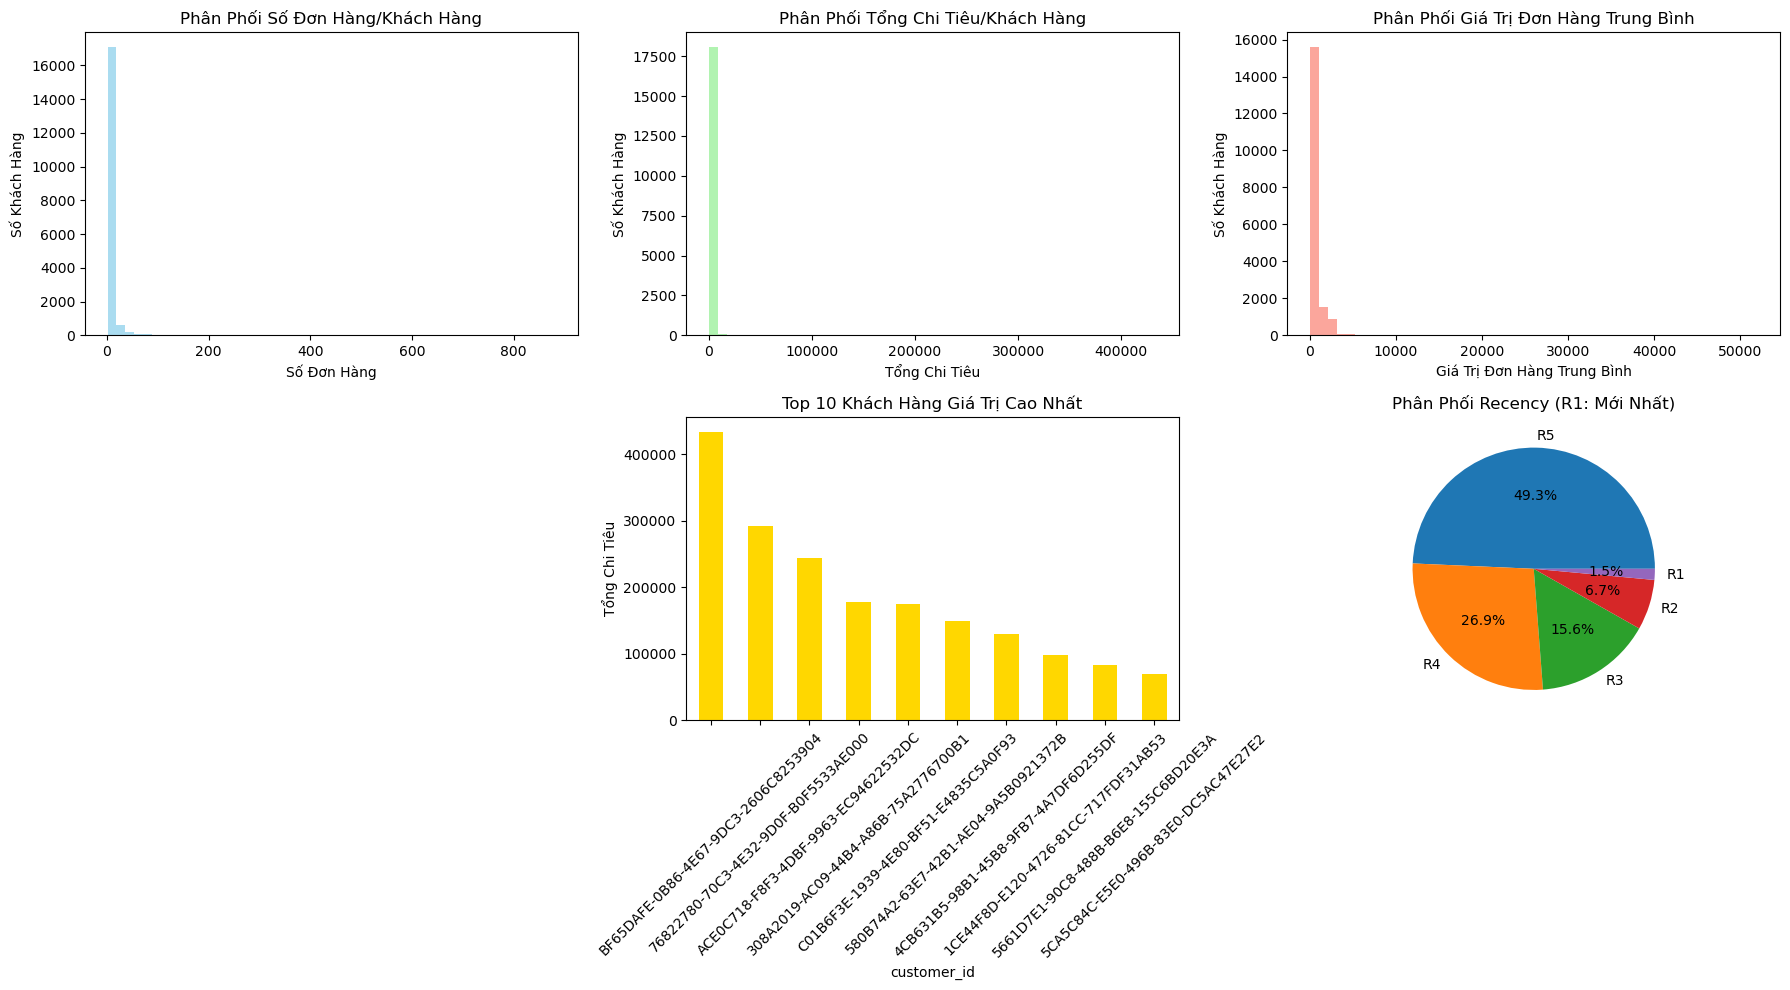

In [6]:
# ===============================
# 👥 PHÂN TÍCH KHÁCH HÀNG
# ===============================
import matplotlib.pyplot as plt
import pandas as pd

def customer_analysis(df):
    """Phân tích hành vi khách hàng"""
    print("\n" + "="*50)
    print("👥 PHÂN TÍCH KHÁCH HÀNG")
    print("="*50)
    
    # Đảm bảo các cột quan trọng tồn tại
    required_cols = ["customer_id", "order_group_id", "catalog_entry_id", 
                     "quantity", "extended_price", "line_item_ordering"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"⚠️ Thiếu cột bắt buộc: {col}")
    
    # Tính toán metrics cho từng khách hàng
    customer_metrics = df.groupby('customer_id').agg({
        'order_group_id': 'nunique',     # số đơn hàng
        'catalog_entry_id': 'nunique',   # số sản phẩm khác nhau
        'quantity': 'sum',               # tổng số lượng mua
        'extended_price': 'sum',         # tổng giá trị mua
        'line_item_ordering': ['min', 'max']  # thời gian đầu và cuối
    }).round(2)
    
    customer_metrics.columns = ['total_orders', 'unique_products', 'total_quantity', 
                               'total_spent', 'first_purchase', 'last_purchase']
    
    # Giá trị trung bình mỗi đơn hàng
    customer_metrics['avg_order_value'] = (
        customer_metrics['total_spent'] / customer_metrics['total_orders']
    ).round(2)
    
    print("📊 THỐNG KÊ KHÁCH HÀNG (describe):")
    print(customer_metrics.describe())
    
    # Nếu có customer_segment thì phân tích, nếu không thì bỏ qua
    if "customer_segment" in df.columns:
        print(f"\n🎯 PHÂN PHỐI CUSTOMER SEGMENTS:")
        segment_dist = df['customer_segment'].value_counts()
        print(segment_dist)
    else:
        print("\n⚠️ Chưa có cột 'customer_segment', bỏ qua phân tích phân khúc.")
        segment_dist = None
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Phân phối số đơn hàng/khách hàng
    axes[0,0].hist(customer_metrics['total_orders'], bins=50, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Phân Phối Số Đơn Hàng/Khách Hàng')
    axes[0,0].set_xlabel('Số Đơn Hàng')
    axes[0,0].set_ylabel('Số Khách Hàng')
    
    # Phân phối tổng chi tiêu
    axes[0,1].hist(customer_metrics['total_spent'], bins=50, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Phân Phối Tổng Chi Tiêu/Khách Hàng')
    axes[0,1].set_xlabel('Tổng Chi Tiêu')
    axes[0,1].set_ylabel('Số Khách Hàng')
    
    # Phân phối giá trị đơn hàng trung bình
    axes[0,2].hist(customer_metrics['avg_order_value'], bins=50, alpha=0.7, color='salmon')
    axes[0,2].set_title('Phân Phối Giá Trị Đơn Hàng Trung Bình')
    axes[0,2].set_xlabel('Giá Trị Đơn Hàng Trung Bình')
    axes[0,2].set_ylabel('Số Khách Hàng')
    
    # Customer segments nếu có
    if segment_dist is not None:
        segment_dist.plot(kind='bar', ax=axes[1,0], 
                          color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
        axes[1,0].set_title('Phân Phối Customer Segments')
        axes[1,0].set_ylabel('Số Khách Hàng')
        axes[1,0].tick_params(axis='x', rotation=45)
    else:
        axes[1,0].set_visible(False)  # ẩn biểu đồ
    
    # Top 10 khách hàng có giá trị cao nhất
    top_customers = customer_metrics.nlargest(10, 'total_spent')['total_spent']
    top_customers.plot(kind='bar', ax=axes[1,1], color='gold')
    axes[1,1].set_title('Top 10 Khách Hàng Giá Trị Cao Nhất')
    axes[1,1].set_ylabel('Tổng Chi Tiêu')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # RFM Analysis đơn giản - Recency
    customer_metrics['recency_days'] = (
        pd.to_datetime('today') - customer_metrics['last_purchase']
    ).dt.days
    recency_groups = pd.cut(customer_metrics['recency_days'], bins=5, 
                            labels=['R5', 'R4', 'R3', 'R2', 'R1'])
    recency_groups.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                       ax=axes[1,2], ylabel="")
    axes[1,2].set_title('Phân Phối Recency (R1: Mới Nhất)')
    
    plt.tight_layout()
    plt.show()
    
    return customer_metrics

# ===============================
# 📤 GỌI HÀM
# ===============================
customer_metrics = customer_analysis(df_clean)



⏰ PHÂN TÍCH THEO THỜI GIAN
📅 Phạm vi thời gian: 2017-08-21 21:13:31.130000 → 2024-10-30 16:26:00.753000
📊 Tổng số ngày có giao dịch: 2,436
📊 Tổng số tháng có giao dịch: 87
📈 Trung bình giao dịch/ngày: 62.1


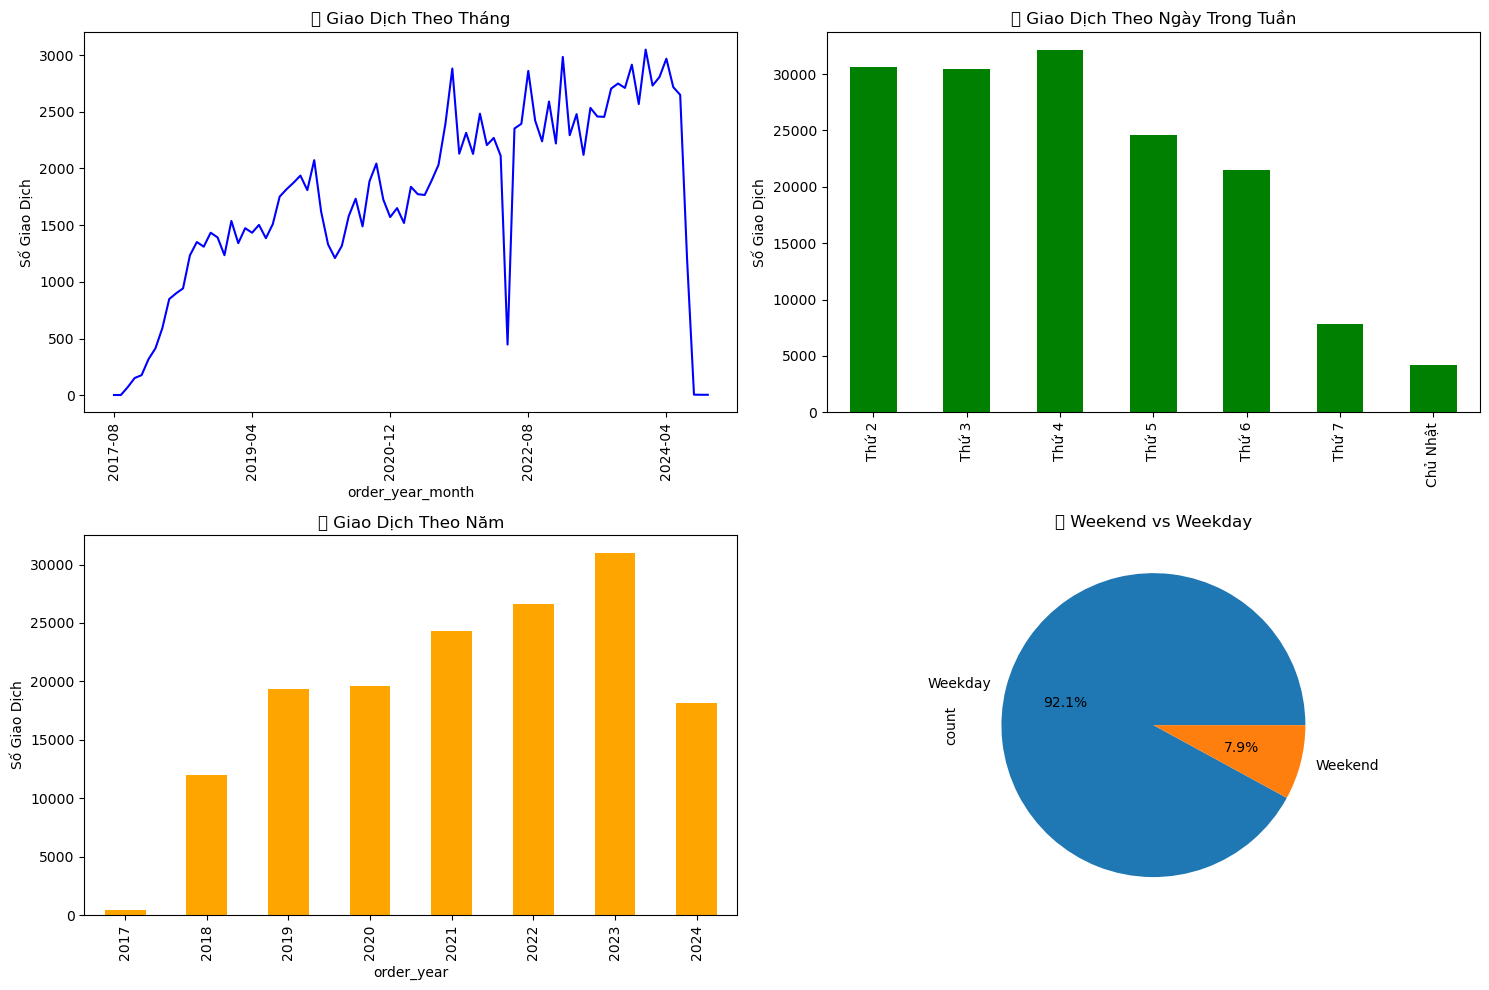

In [7]:
# ===============================
# ⏰ PHÂN TÍCH THỜI GIAN - FIX
# ===============================
import matplotlib.pyplot as plt

def temporal_analysis(df):
    """Phân tích xu hướng theo thời gian cho recommender data"""
    if 'line_item_ordering' not in df.columns:
        print("⚠️ Không có cột 'line_item_ordering' trong dữ liệu")
        return df
    
    print("\n" + "="*50)
    print("⏰ PHÂN TÍCH THEO THỜI GIAN")
    print("="*50)
    
    df_temp = df.copy()
    
    # Tạo biến thời gian
    df_temp['order_date'] = df_temp['line_item_ordering'].dt.date
    df_temp['order_year_month'] = df_temp['line_item_ordering'].dt.to_period('M').astype(str)  # ⚡ convert sang chuỗi
    df_temp['order_year'] = df_temp['line_item_ordering'].dt.year
    df_temp['order_dayofweek'] = df_temp['line_item_ordering'].dt.dayofweek
    df_temp['is_weekend'] = df_temp['order_dayofweek'].isin([5,6]).astype(int)
    
    # Thống kê cơ bản
    daily_orders = df_temp.groupby('order_date').size()
    monthly_orders = df_temp.groupby('order_year_month').size()
    
    print(f"📅 Phạm vi thời gian: {df_temp['line_item_ordering'].min()} → {df_temp['line_item_ordering'].max()}")
    print(f"📊 Tổng số ngày có giao dịch: {len(daily_orders):,}")
    print(f"📊 Tổng số tháng có giao dịch: {len(monthly_orders):,}")
    print(f"📈 Trung bình giao dịch/ngày: {daily_orders.mean():.1f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Giao dịch theo tháng (⚡ x-axis = YYYY-MM)
    monthly_orders.plot(ax=axes[0,0], kind='line', title='📅 Giao Dịch Theo Tháng', color='blue')
    axes[0,0].set_ylabel('Số Giao Dịch')
    axes[0,0].tick_params(axis='x', rotation=90)   # quay nhãn 90° cho dễ đọc
    
    # 2. Giao dịch theo ngày trong tuần
    dayofweek_orders = df_temp['order_dayofweek'].value_counts().sort_index()
    days = ['Thứ 2', 'Thứ 3', 'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ Nhật']
    dayofweek_orders.index = days
    dayofweek_orders.plot(ax=axes[0,1], kind='bar', title='📊 Giao Dịch Theo Ngày Trong Tuần', color='green')
    axes[0,1].set_ylabel('Số Giao Dịch')
    
    # 3. Giao dịch theo năm
    year_orders = df_temp['order_year'].value_counts().sort_index()
    year_orders.plot(ax=axes[1,0], kind='bar', title='📆 Giao Dịch Theo Năm', color='orange')
    axes[1,0].set_ylabel('Số Giao Dịch')
    
    # 4. Weekend vs Weekday
    weekend_orders = df_temp['is_weekend'].value_counts().sort_index()
    weekend_orders.index = ['Weekday', 'Weekend']
    weekend_orders.plot(ax=axes[1,1], kind='pie', autopct='%1.1f%%', title='📊 Weekend vs Weekday')
    
    plt.tight_layout()
    plt.show()
    
    return df_temp

# ===============================
# 📤 GỌI HÀM
# ===============================
df_with_time = temporal_analysis(df_clean)



👥 PHÂN TÍCH KHÁCH HÀNG
📊 THỐNG KÊ KHÁCH HÀNG:
       total_orders  unique_products  total_quantity    total_spent  \
count  18224.000000     18224.000000    18224.000000   18224.000000   
mean       5.732880         6.859800       51.058714     825.809833   
min        1.000000         1.000000        1.000000       0.000000   
25%        1.000000         1.000000        1.000000      22.470000   
50%        1.000000         1.000000        2.000000      87.750000   
75%        3.000000         4.000000       16.000000     882.522500   
max      882.000000      1414.000000    50717.000000  433969.750000   
std       22.481588        30.346365      645.509551    5381.468691   

                      first_purchase                  last_purchase  \
count                          18224                          18224   
mean   2021-11-30 01:29:26.889275904  2022-12-11 04:57:30.826675200   
min       2017-08-21 21:13:31.130000     2017-08-21 21:13:31.130000   
25%    2020-08-03 07:03:44.77

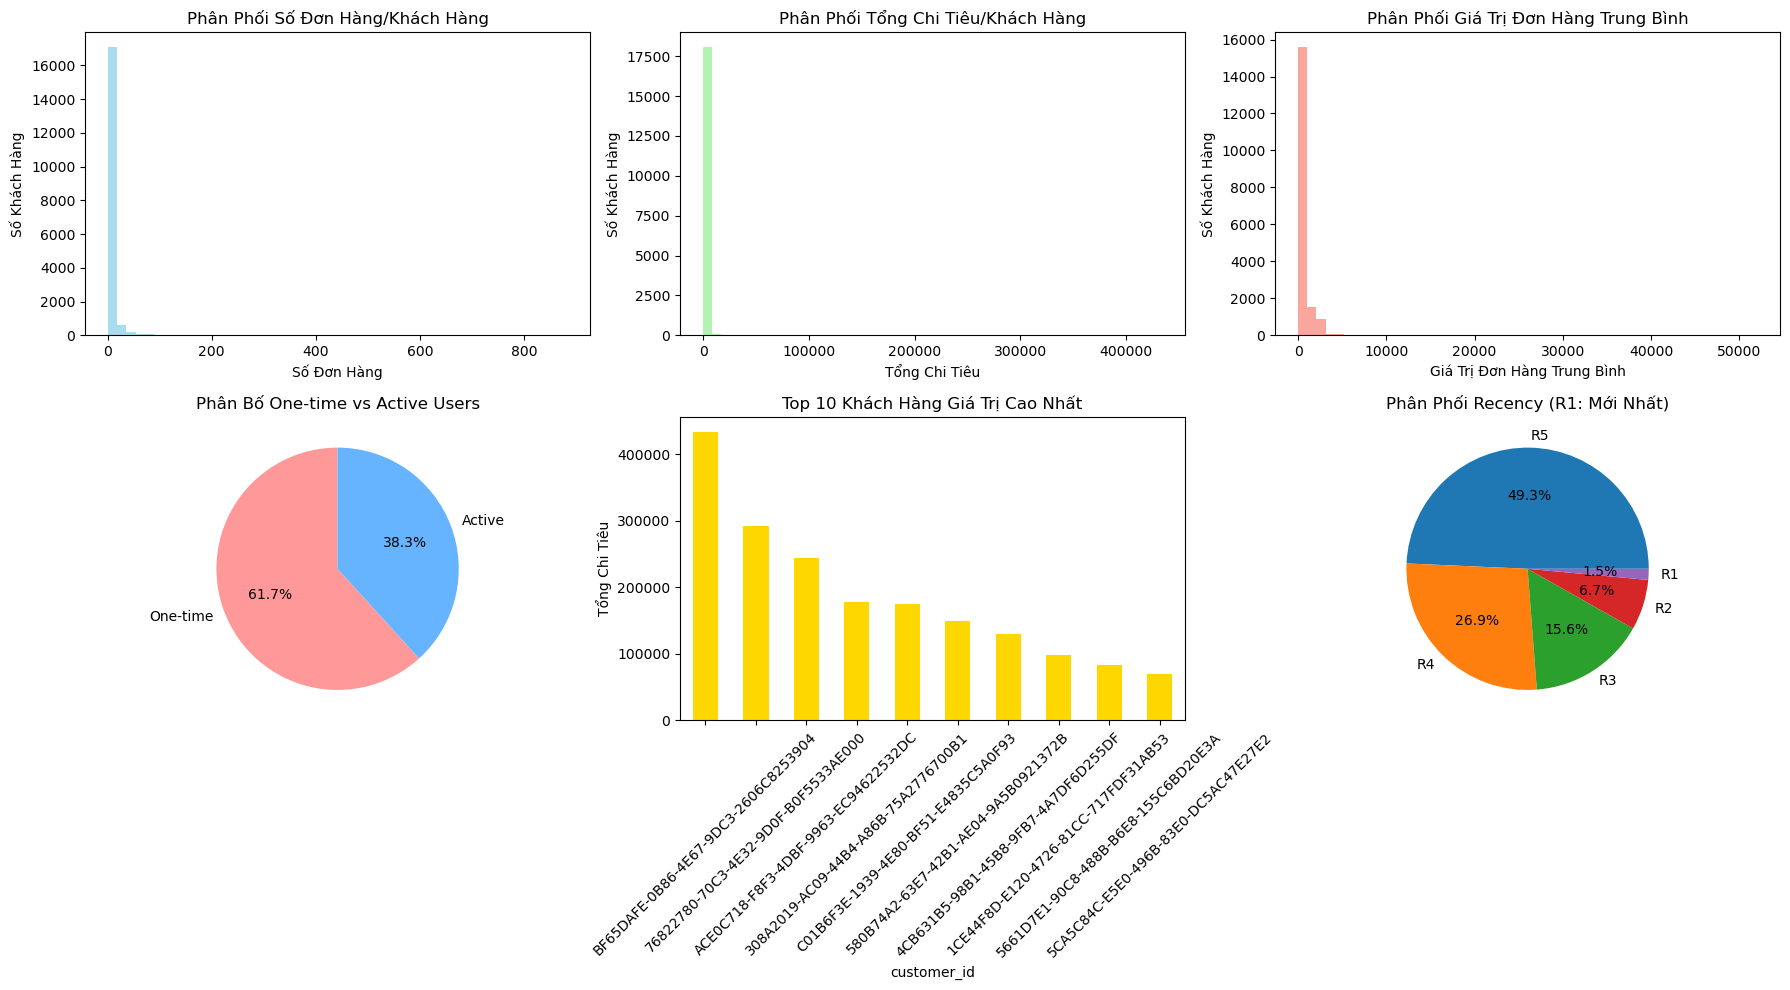

In [8]:
# ===============================
# 👥 PHÂN TÍCH KHÁCH HÀNG
# ===============================
import matplotlib.pyplot as plt
import pandas as pd

def customer_analysis(df):
    """Phân tích hành vi khách hàng cho recommender data"""
    print("\n" + "="*50)
    print("👥 PHÂN TÍCH KHÁCH HÀNG")
    print("="*50)
    
    # Kiểm tra cột cần thiết
    required_cols = ["customer_id", "order_group_id", "catalog_entry_id", 
                     "quantity", "extended_price", "line_item_ordering"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"⚠️ Thiếu cột bắt buộc: {col}")
    
    # Tính toán metrics cho từng khách hàng
    customer_metrics = df.groupby("customer_id").agg({
        "order_group_id": "nunique",   # số đơn hàng
        "catalog_entry_id": "nunique", # số sản phẩm khác nhau
        "quantity": "sum",             # tổng số lượng mua
        "extended_price": "sum",       # tổng chi tiêu
        "line_item_ordering": ["min", "max"]  # lần mua đầu và cuối
    }).round(2)

    customer_metrics.columns = ["total_orders", "unique_products", 
                                "total_quantity", "total_spent", 
                                "first_purchase", "last_purchase"]

    # Giá trị trung bình mỗi đơn hàng
    customer_metrics["avg_order_value"] = customer_metrics["total_spent"] / customer_metrics["total_orders"]

    print("📊 THỐNG KÊ KHÁCH HÀNG:")
    print(customer_metrics.describe())

    # ===============================
    # 🟠 One-time vs Active Users
    # ===============================
    one_time_count = (customer_metrics["total_orders"] == 1).sum()
    active_count = (customer_metrics["total_orders"] > 1).sum()
    total_customers = len(customer_metrics)

    print("\n🎯 PHÂN LOẠI KHÁCH HÀNG:")
    print(f"🟠 One-time users (1 đơn hàng): {one_time_count:,} ({one_time_count/total_customers:.1%})")
    print(f"🟢 Active users (>=2 đơn hàng): {active_count:,} ({active_count/total_customers:.1%})")

    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Phân phối số đơn hàng/khách hàng
    orders_per_customer = customer_metrics["total_orders"]
    axes[0,0].hist(orders_per_customer, bins=50, alpha=0.7, color="skyblue")
    axes[0,0].set_title("Phân Phối Số Đơn Hàng/Khách Hàng")
    axes[0,0].set_xlabel("Số Đơn Hàng")
    axes[0,0].set_ylabel("Số Khách Hàng")
    
    # 2. Phân phối tổng chi tiêu
    axes[0,1].hist(customer_metrics["total_spent"], bins=50, alpha=0.7, color="lightgreen")
    axes[0,1].set_title("Phân Phối Tổng Chi Tiêu/Khách Hàng")
    axes[0,1].set_xlabel("Tổng Chi Tiêu")
    axes[0,1].set_ylabel("Số Khách Hàng")
    
    # 3. Phân phối giá trị đơn hàng trung bình
    axes[0,2].hist(customer_metrics["avg_order_value"], bins=50, alpha=0.7, color="salmon")
    axes[0,2].set_title("Phân Phối Giá Trị Đơn Hàng Trung Bình")
    axes[0,2].set_xlabel("Giá Trị Đơn Hàng Trung Bình")
    axes[0,2].set_ylabel("Số Khách Hàng")
    
    # 4. One-time vs Active pie chart
    axes[1,0].pie([one_time_count, active_count], 
                  labels=["One-time", "Active"], autopct="%1.1f%%", 
                  colors=["#ff9999", "#66b3ff"], startangle=90)
    axes[1,0].set_title("Phân Bố One-time vs Active Users")
    
    # 5. Top 10 khách hàng giá trị cao nhất
    top_customers = customer_metrics.nlargest(10, "total_spent")["total_spent"]
    top_customers.plot(kind="bar", ax=axes[1,1], color="gold")
    axes[1,1].set_title("Top 10 Khách Hàng Giá Trị Cao Nhất")
    axes[1,1].set_ylabel("Tổng Chi Tiêu")
    axes[1,1].tick_params(axis="x", rotation=45)
    
    # 6. Recency (RFM đơn giản)
    customer_metrics["recency_days"] = (pd.to_datetime("today") - customer_metrics["last_purchase"]).dt.days
    recency_groups = pd.cut(customer_metrics["recency_days"], bins=5, labels=["R5", "R4", "R3", "R2", "R1"])
    axes[1,2].pie(recency_groups.value_counts(), autopct="%1.1f%%", 
                  labels=recency_groups.value_counts().index)
    axes[1,2].set_title("Phân Phối Recency (R1: Mới Nhất)")
    
    plt.tight_layout()
    plt.show()
    
    return customer_metrics

# ===============================
# 📤 GỌI HÀM
# ===============================
customer_metrics = customer_analysis(df_clean)


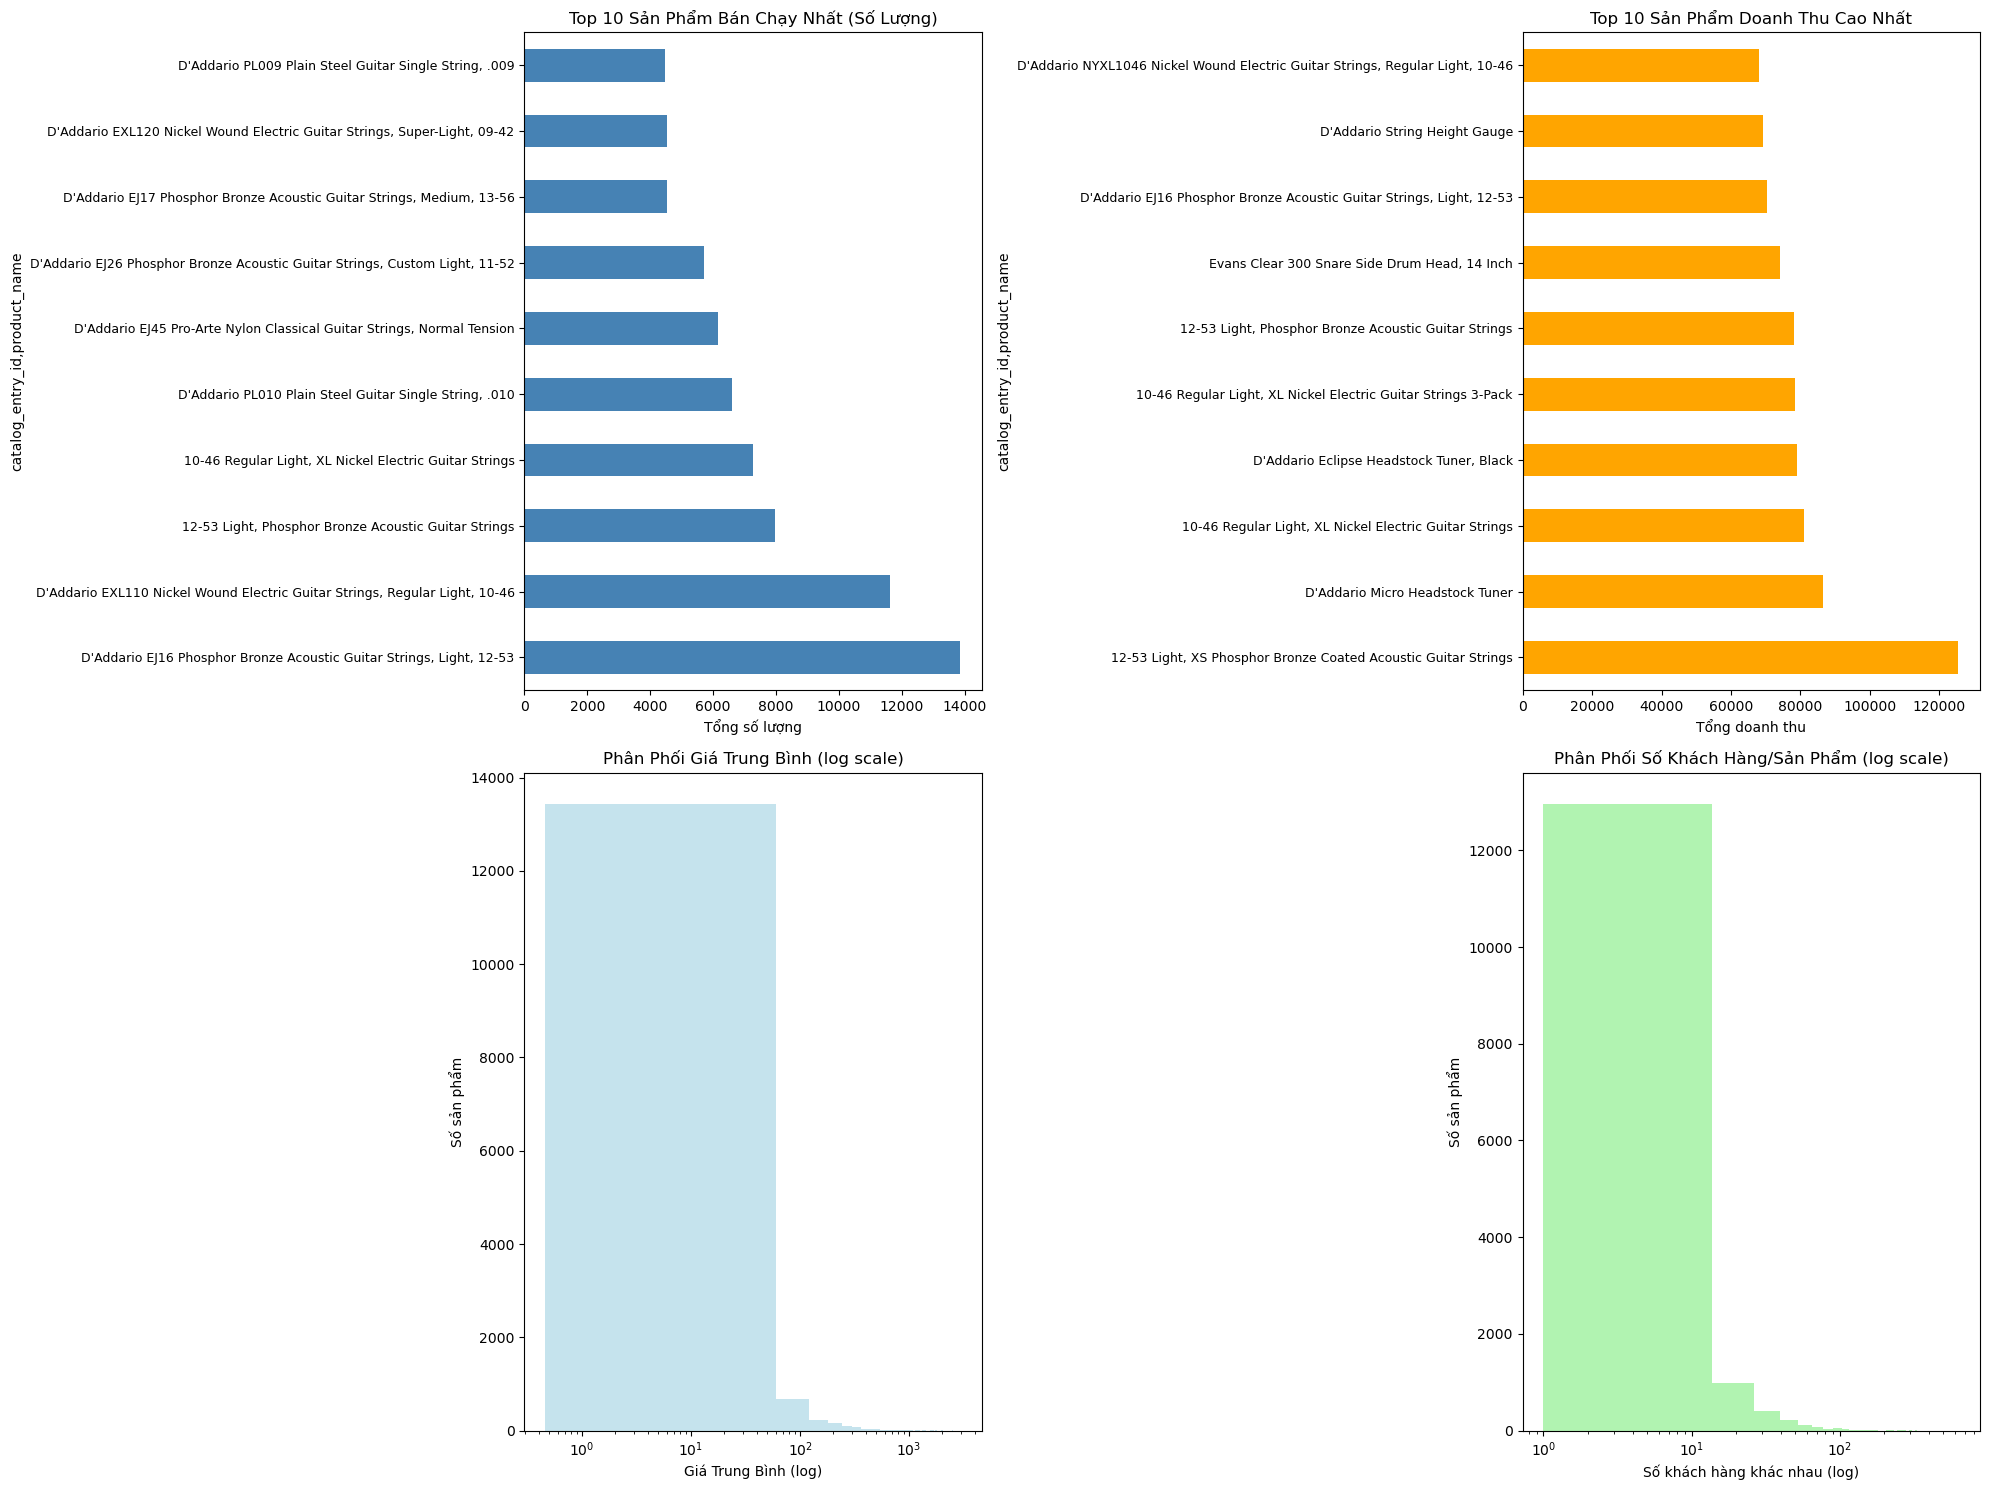

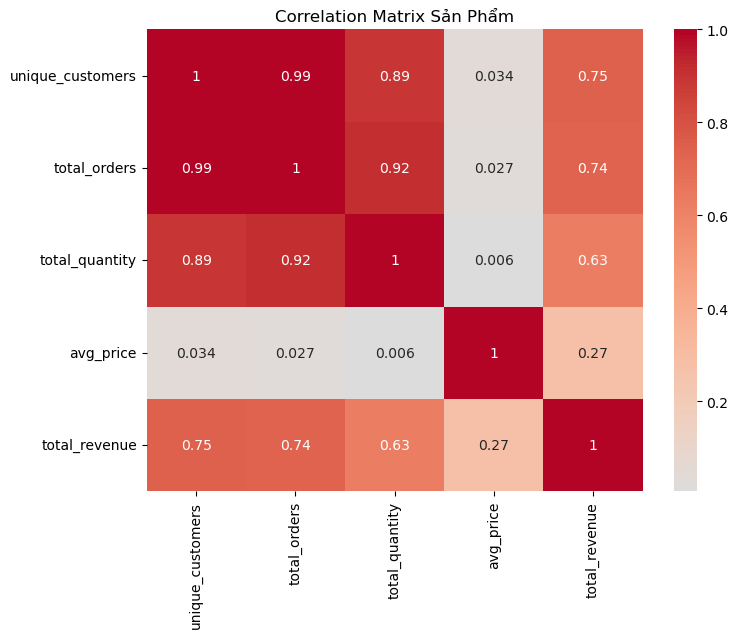

In [9]:
def product_analysis_v2(df):
    """Phân tích sản phẩm (phiên bản đẹp hơn)"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    product_metrics = df.groupby(['catalog_entry_id', 'product_name']).agg({
        'customer_id': 'nunique',
        'order_group_id': 'nunique',
        'quantity': 'sum',
        'placed_price': ['mean', 'std'],
        'extended_price': 'sum'
    }).round(2)
    product_metrics.columns = ['unique_customers','total_orders','total_quantity',
                               'avg_price','price_std','total_revenue']
    
    product_metrics['avg_quantity_per_order'] = (
        product_metrics['total_quantity'] / product_metrics['total_orders']
    )

    # --- Visualization ---
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # 1. Top 10 bán chạy
    top_qty = product_metrics.nlargest(10, 'total_quantity')
    top_qty['total_quantity'].plot(kind='barh', ax=axes[0,0], color='steelblue')
    axes[0,0].set_title("Top 10 Sản Phẩm Bán Chạy Nhất (Số Lượng)")
    axes[0,0].set_xlabel("Tổng số lượng")
    axes[0,0].set_yticklabels(top_qty.index.get_level_values(1), fontsize=9)

    # 2. Top 10 doanh thu
    top_rev = product_metrics.nlargest(10, 'total_revenue')
    top_rev['total_revenue'].plot(kind='barh', ax=axes[0,1], color='orange')
    axes[0,1].set_title("Top 10 Sản Phẩm Doanh Thu Cao Nhất")
    axes[0,1].set_xlabel("Tổng doanh thu")
    axes[0,1].set_yticklabels(top_rev.index.get_level_values(1), fontsize=9)

    # 3. Phân phối giá trung bình (log-scale)
    axes[1,0].hist(product_metrics['avg_price'], bins=50, color='lightblue', alpha=0.7)
    axes[1,0].set_xscale('log')
    axes[1,0].set_title("Phân Phối Giá Trung Bình (log scale)")
    axes[1,0].set_xlabel("Giá Trung Bình (log)")
    axes[1,0].set_ylabel("Số sản phẩm")

    # 4. Phân phối số khách hàng/sản phẩm (log-scale)
    axes[1,1].hist(product_metrics['unique_customers'], bins=50, color='lightgreen', alpha=0.7)
    axes[1,1].set_xscale('log')
    axes[1,1].set_title("Phân Phối Số Khách Hàng/Sản Phẩm (log scale)")
    axes[1,1].set_xlabel("Số khách hàng khác nhau (log)")
    axes[1,1].set_ylabel("Số sản phẩm")

    plt.tight_layout()
    plt.show()

    # Correlation matrix riêng
    plt.figure(figsize=(8,6))
    sns.heatmap(product_metrics[['unique_customers','total_orders',
                                'total_quantity','avg_price','total_revenue']].corr(),
                annot=True, cmap='coolwarm', center=0)
    plt.title("Correlation Matrix Sản Phẩm")
    plt.show()

    return product_metrics

product_metrics = product_analysis_v2(df_clean)


💰 PHÂN TÍCH GIÁ VÀ SỐ LƯỢNG
📊 THỐNG KÊ GIÁ:
• Giá trung bình: $56.74
• Giá trung vị: $9.22
• Giá cao nhất: $3000.00
• Giá thấp nhất: $0.32

📊 THỐNG KÊ SỐ LƯỢNG:
• Số lượng trung bình: 6.15
• Số lượng trung vị: 3.00
• Số lượng cao nhất: 100.00


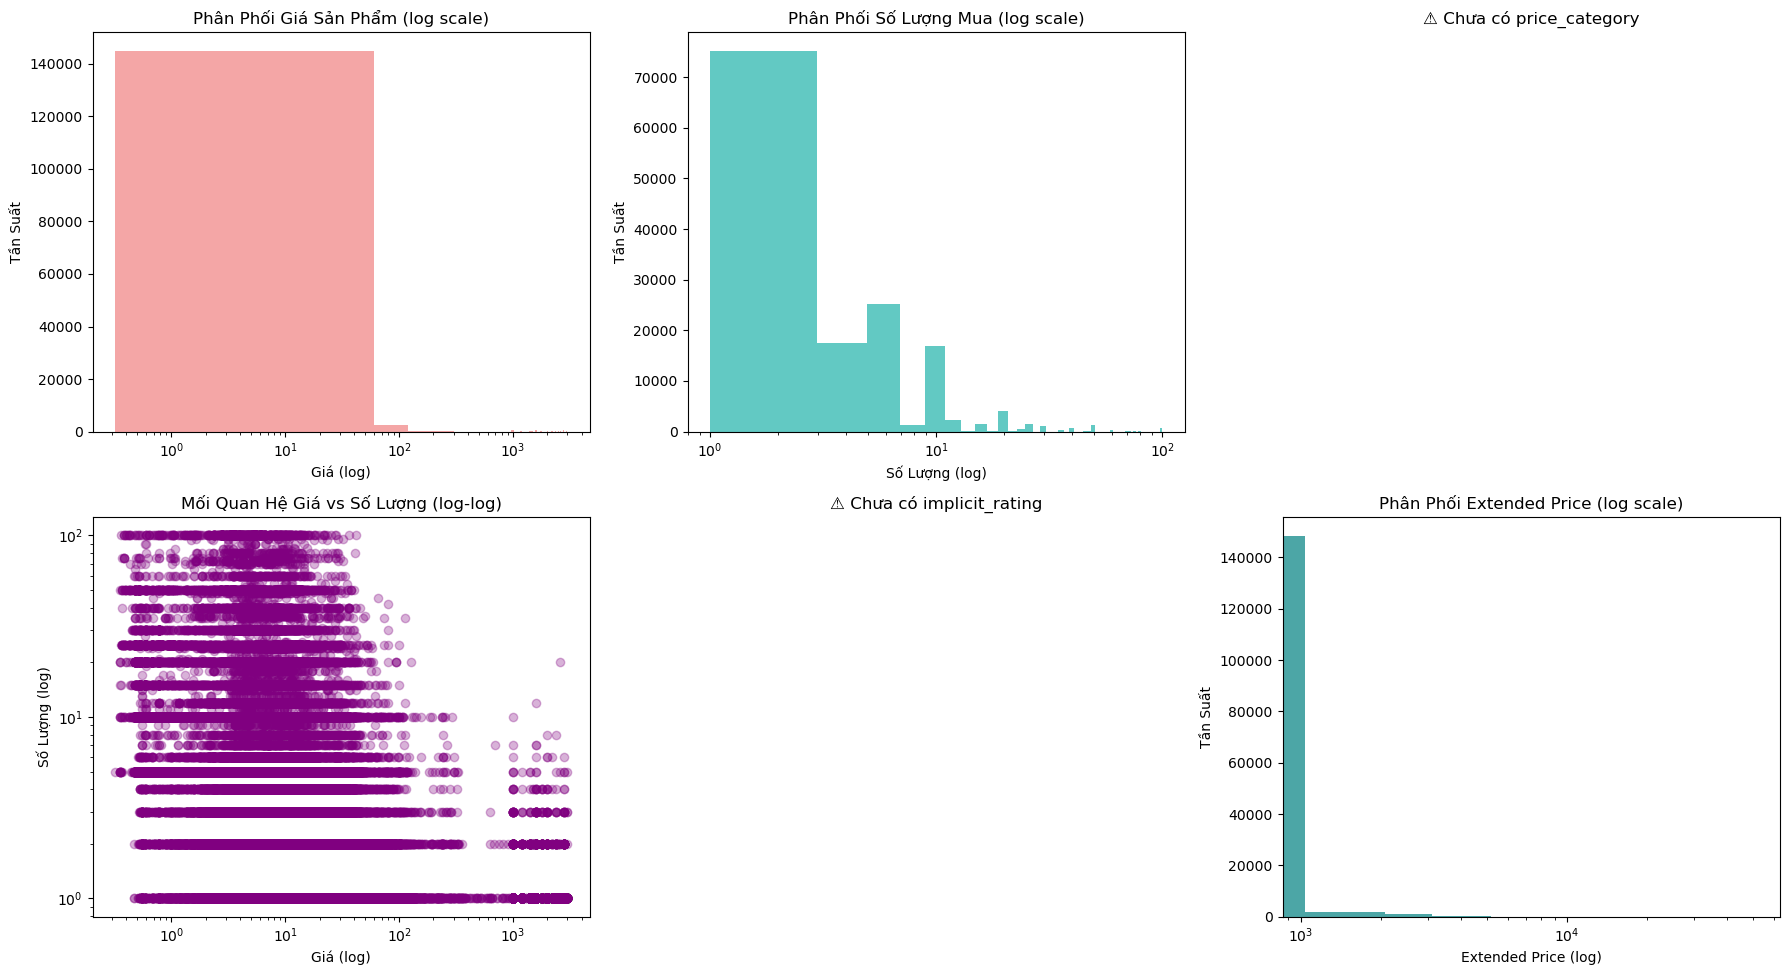


📈 CORRELATION MATRIX:
                quantity  placed_price  extended_price
quantity           1.000        -0.075           0.116
placed_price      -0.075         1.000           0.784
extended_price     0.116         0.784           1.000


In [10]:
# ===============================
# 💰 PHÂN TÍCH GIÁ VÀ SỐ LƯỢNG
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

def price_quantity_analysis(df):
    """Phân tích mối quan hệ giữa giá và số lượng"""
    print("\n" + "="*50)
    print("💰 PHÂN TÍCH GIÁ VÀ SỐ LƯỢNG")
    print("="*50)
    
    # Kiểm tra cột cần thiết
    required_cols = ["placed_price", "quantity", "extended_price"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"⚠️ Thiếu cột bắt buộc: {col}")
    
    # Thống kê cơ bản
    print("📊 THỐNG KÊ GIÁ:")
    print(f"• Giá trung bình: ${df['placed_price'].mean():.2f}")
    print(f"• Giá trung vị: ${df['placed_price'].median():.2f}")
    print(f"• Giá cao nhất: ${df['placed_price'].max():.2f}")
    print(f"• Giá thấp nhất: ${df['placed_price'].min():.2f}")
    
    print("\n📊 THỐNG KÊ SỐ LƯỢNG:")
    print(f"• Số lượng trung bình: {df['quantity'].mean():.2f}")
    print(f"• Số lượng trung vị: {df['quantity'].median():.2f}")
    print(f"• Số lượng cao nhất: {df['quantity'].max():.2f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Phân phối giá (log-scale chống skew)
    axes[0,0].hist(df['placed_price'], bins=50, alpha=0.7, color='lightcoral')
    axes[0,0].set_xscale('log')
    axes[0,0].set_title('Phân Phối Giá Sản Phẩm (log scale)')
    axes[0,0].set_xlabel('Giá (log)')
    axes[0,0].set_ylabel('Tần Suất')
    
    # 2. Phân phối số lượng
    axes[0,1].hist(df['quantity'], bins=50, alpha=0.7, color='lightseagreen')
    axes[0,1].set_xscale('log')
    axes[0,1].set_title('Phân Phối Số Lượng Mua (log scale)')
    axes[0,1].set_xlabel('Số Lượng (log)')
    axes[0,1].set_ylabel('Tần Suất')
    
    # 3. Box plot giá theo price category (nếu có)
    if 'price_category' in df.columns:
        sns.boxplot(x='price_category', y='placed_price', data=df, ax=axes[0,2])
        axes[0,2].set_title('Phân Phối Giá Theo Price Category')
        axes[0,2].set_ylabel('Giá')
    else:
        axes[0,2].axis('off')
        axes[0,2].set_title("⚠️ Chưa có price_category")
    
    # 4. Scatter plot: Giá vs Số lượng (log scale)
    axes[1,0].scatter(df['placed_price'], df['quantity'], alpha=0.3, color='purple')
    axes[1,0].set_xscale('log')
    axes[1,0].set_yscale('log')
    axes[1,0].set_title('Mối Quan Hệ Giá vs Số Lượng (log-log)')
    axes[1,0].set_xlabel('Giá (log)')
    axes[1,0].set_ylabel('Số Lượng (log)')
    
    # 5. Phân phối implicit rating (nếu có)
    if 'implicit_rating' in df.columns:
        axes[1,1].hist(df['implicit_rating'], bins=50, alpha=0.7, color='gold')
        axes[1,1].set_title('Phân Phối Implicit Rating')
        axes[1,1].set_xlabel('Implicit Rating')
        axes[1,1].set_ylabel('Tần Suất')
    else:
        axes[1,1].axis('off')
        axes[1,1].set_title("⚠️ Chưa có implicit_rating")
    
    # 6. Phân phối extended price (log-scale)
    axes[1,2].hist(df['extended_price'], bins=50, alpha=0.7, color='teal')
    axes[1,2].set_xscale('log')
    axes[1,2].set_title('Phân Phối Extended Price (log scale)')
    axes[1,2].set_xlabel('Extended Price (log)')
    axes[1,2].set_ylabel('Tần Suất')
    
    plt.suptitle('')
    plt.tight_layout()
    plt.show()
    
    # Correlation analysis
    numeric_cols = ['quantity', 'placed_price', 'extended_price']
    if 'implicit_rating' in df.columns:
        numeric_cols.append('implicit_rating')
    
    correlation_matrix = df[numeric_cols].corr()
    print("\n📈 CORRELATION MATRIX:")
    print(correlation_matrix.round(3))

# 📤 Gọi hàm
price_quantity_analysis(df_clean)



🌍 PHÂN TÍCH THỊ TRƯỜNG VÀ ĐƠN HÀNG
📊 PHÂN TÍCH THEO THỊ TRƯỜNG:
           unique_customers  total_orders  total_revenue  total_quantity  \
market_id                                                                  
DUS                    7239          7740     5187528.33         11078.0   
BUSD3                  3370         42544     2352526.92        271719.0   
BUSE5                    99          3297     1977783.34        247298.0   
BEUD3                  2280         17196      960321.41        122280.0   
DUK                     569           595      729886.82           705.0   
BUSD9I                  145          7496      658401.35         78425.0   
DCA                     591           630      604461.69           791.0   
DEU                     364           381      573241.27           466.0   
BEUD6                   112          4459      489079.33         55272.0   
BUKD3                   593          9740      363770.80         57375.0   

           avg_order_v

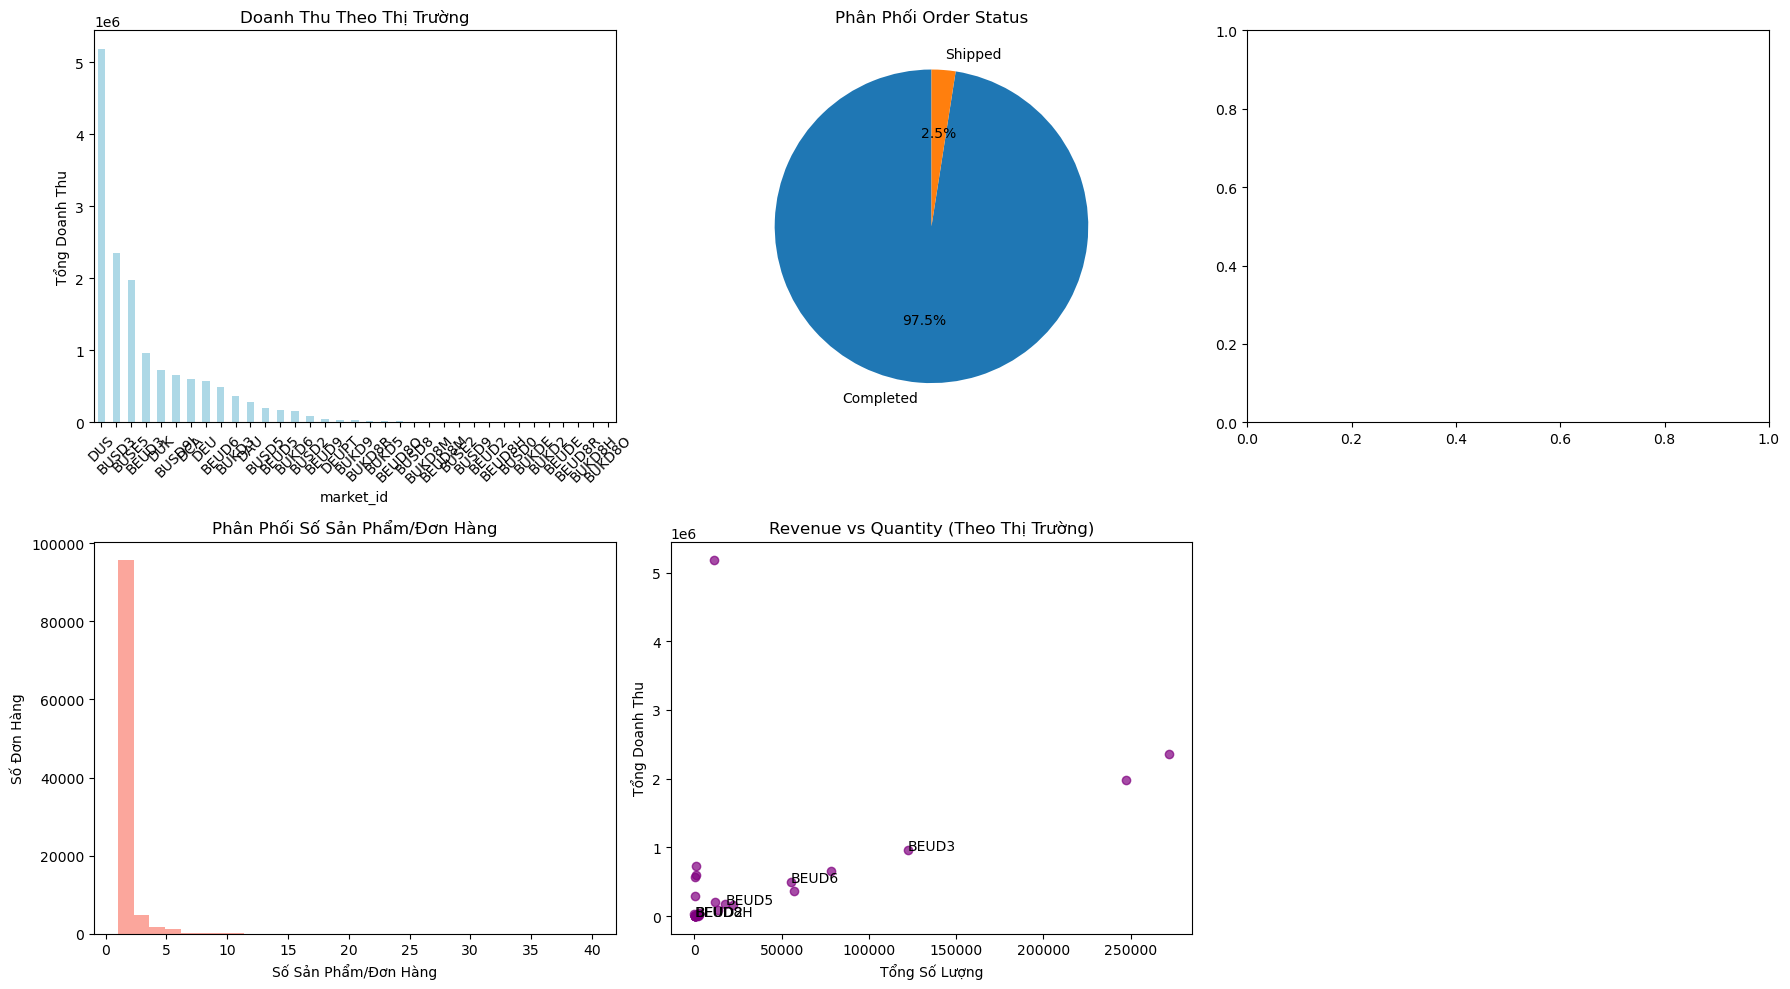

In [11]:
# ===============================
# 🌍 PHÂN TÍCH THỊ TRƯỜNG VÀ ĐƠN HÀNG
# ===============================
import matplotlib.pyplot as plt

def market_order_analysis(df):
    """Phân tích theo thị trường và đơn hàng"""
    print("\n" + "="*50)
    print("🌍 PHÂN TÍCH THỊ TRƯỜNG VÀ ĐƠN HÀNG")
    print("="*50)
    
    market_analysis, status_dist, currency_dist = None, None, None
    
    # 1. Phân tích theo MarketId
    if 'market_id' in df.columns:
        market_analysis = df.groupby('market_id').agg({
            'customer_id': 'nunique',
            'order_group_id': 'nunique',
            'extended_price': 'sum',
            'quantity': 'sum'
        }).round(2)
        
        market_analysis.columns = ['unique_customers', 'total_orders', 'total_revenue', 'total_quantity']
        market_analysis['avg_order_value'] = (
            market_analysis['total_revenue'] / market_analysis['total_orders']
        ).round(2)
        
        # Thống kê top markets
        print("📊 PHÂN TÍCH THEO THỊ TRƯỜNG:")
        print(market_analysis.sort_values('total_revenue', ascending=False).head(10))
        print(f"🌎 Số thị trường: {market_analysis.shape[0]}")
        
        # Top 5 theo AOV
        top5_aov = market_analysis.sort_values('avg_order_value', ascending=False).head(5)
        print("\n💰 TOP 5 THỊ TRƯỜNG THEO AOV (Average Order Value):")
        print(top5_aov[['total_orders', 'total_revenue', 'avg_order_value']])
    
    # 2. Phân tích theo OrderStatus
    if 'order_status' in df.columns:
        status_dist = df['order_status'].value_counts()
        print(f"\n📊 PHÂN PHỐI ORDER STATUS:")
        print(status_dist)
    
    # 3. Phân tích theo BillingCurrency
    if 'billing_currency' in df.columns:
        currency_dist = df['billing_currency'].value_counts()
        print(f"\n💰 PHÂN PHỐI CURRENCY:")
        print(currency_dist)
    
    # ======================
    # 📊 Visualization
    # ======================
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Revenue theo thị trường
    if market_analysis is not None:
        market_analysis.sort_values('total_revenue', ascending=False)['total_revenue'] \
            .plot(kind='bar', ax=axes[0,0], color='lightblue')
        axes[0,0].set_title('Doanh Thu Theo Thị Trường')
        axes[0,0].set_ylabel('Tổng Doanh Thu')
        axes[0,0].tick_params(axis='x', rotation=45)
    
    # Order status distribution
    if status_dist is not None:
        status_dist.plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%', startangle=90)
        axes[0,1].set_ylabel('')
        axes[0,1].set_title('Phân Phối Order Status')
    
    # Currency distribution
    if currency_dist is not None:
        currency_dist.plot(kind='bar', ax=axes[0,2], color='lightgreen')
        axes[0,2].set_title('Phân Phối Currency')
        axes[0,2].set_ylabel('Số Giao Dịch')
        axes[0,2].tick_params(axis='x', rotation=45)
    
    # Items per order analysis
    if 'order_group_id' in df.columns:
        items_per_order = df.groupby('order_group_id').size()
        axes[1,0].hist(items_per_order, bins=30, alpha=0.7, color='salmon')
        axes[1,0].set_title('Phân Phối Số Sản Phẩm/Đơn Hàng')
        axes[1,0].set_xlabel('Số Sản Phẩm/Đơn Hàng')
        axes[1,0].set_ylabel('Số Đơn Hàng')
    
    # Scatter plot: Revenue vs Quantity (theo MarketId)
    if market_analysis is not None:
        axes[1,1].scatter(market_analysis['total_quantity'], market_analysis['total_revenue'],
                          alpha=0.7, color='purple')
        for i, txt in enumerate(market_analysis.index):
            if i < 5:  # annotate top 5 markets
                axes[1,1].annotate(txt, 
                                   (market_analysis['total_quantity'].iloc[i], 
                                    market_analysis['total_revenue'].iloc[i]))
        axes[1,1].set_title('Revenue vs Quantity (Theo Thị Trường)')
        axes[1,1].set_xlabel('Tổng Số Lượng')
        axes[1,1].set_ylabel('Tổng Doanh Thu')
    
    # Bỏ trống ô cuối (axes[1,2]) để tránh lỗi
    axes[1,2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return market_analysis

# ===============================
# 📤 GỌI HÀM
# ===============================
market_stats = market_order_analysis(df_clean)


In [12]:
# ===============================
# 🎯 KẾT LUẬN EDA VÀ INSIGHTS
# ===============================
def eda_conclusions(df):
    """Tổng kết insights từ EDA"""
    print("\n" + "="*60)
    print("🎯 KẾT LUẬN EDA VÀ INSIGHTS")
    print("="*60)
    
    # Key metrics
    total_customers = df['customer_id'].nunique()
    total_products = df['catalog_entry_id'].nunique()
    total_orders = df['order_group_id'].nunique()
    total_revenue = df['extended_price'].sum()
    
    print("📈 KEY METRICS:")
    print(f"• Tổng số khách hàng: {total_customers:,}")
    print(f"• Tổng số sản phẩm: {total_products:,}")
    print(f"• Tổng số đơn hàng: {total_orders:,}")
    print(f"• Tổng doanh thu: ${total_revenue:,.2f}")
    print(f"• Doanh thu trung bình/khách hàng: ${total_revenue/total_customers:,.2f}")
    print(f"• Số đơn hàng trung bình/khách hàng: {total_orders/total_customers:.2f}")
    
    # Data sparsity
    total_interactions = len(df)
    possible_interactions = total_customers * total_products
    sparsity = (1 - (total_interactions / possible_interactions)) * 100
    
    print(f"\n📊 DATA SPARSITY CHO RECOMMENDATION SYSTEM:")
    print(f"• Tổng tương tác: {total_interactions:,}")
    print(f"• Tổng tương tác có thể: {possible_interactions:,}")
    print(f"• Độ sparse: {sparsity:.4f}%")
    
    # Business insights
    print(f"\n💡 BUSINESS INSIGHTS:")
    
    # Top 5 products theo revenue
    top_products = df.groupby(['catalog_entry_id', 'product_name'])['extended_price'].sum().nlargest(5)
    print("• Top 5 sản phẩm doanh thu cao nhất:")
    for idx, (product_id, product_name) in enumerate(top_products.index, 1):
        revenue = top_products.loc[(product_id, product_name)]
        print(f"  {idx}. {product_name} - ${revenue:,.2f}")
    
    # Top 5 khách hàng chi tiêu nhiều nhất
    top_customers = df.groupby('customer_id')['extended_price'].sum().nlargest(5)
    print("\n• Top 5 khách hàng chi tiêu nhiều nhất:")
    for idx, (cust_id, spent) in enumerate(top_customers.items(), 1):
        print(f"  {idx}. {cust_id} - ${spent:,.2f}")
    
    # Customer segments distribution
    if 'customer_segment' in df.columns:
        segment_pct = df['customer_segment'].value_counts(normalize=True) * 100
        print(f"\n• Phân phối customer segments:")
        for segment, pct in segment_pct.items():
            print(f"  {segment}: {pct:.1f}%")
    
    # Price distribution insights
    if 'price_category' in df.columns:
        price_pct = df['price_category'].value_counts(normalize=True) * 100
        print(f"\n• Phân phối giá sản phẩm:")
        for category, pct in price_pct.items():
            print(f"  {category}: {pct:.1f}%")
    
    # Skewness check
    print("\n📉 KIỂM TRA SKEWNESS (Độ lệch phân phối):")
    if 'placed_price' in df.columns:
        print(f"• Skewness PlacedPrice: {df['placed_price'].skew():.2f}")
    if 'quantity' in df.columns:
        print(f"• Skewness Quantity: {df['quantity'].skew():.2f}")
    
    # Recommendation implications
    print(f"\n🎯 RECOMMENDATION SYSTEM IMPLICATIONS:")
    print("• Collaborative Filtering: Khả thi với số lượng khách hàng và sản phẩm hiện có")
    print("• Content-Based: Có thể sử dụng price categories và product features")
    print("• Hybrid Approach: Kết hợp cả hai phương pháp cho kết quả tốt nhất")
    print("• Cold Start Problem: Cần xử lý cho khách hàng mới và sản phẩm mới")

# ===============================
# 📤 GỌI HÀM
# ===============================
eda_conclusions(df_clean)


🎯 KẾT LUẬN EDA VÀ INSIGHTS
📈 KEY METRICS:
• Tổng số khách hàng: 18,224
• Tổng số sản phẩm: 6,094
• Tổng số đơn hàng: 104,476
• Tổng doanh thu: $15,049,558.39
• Doanh thu trung bình/khách hàng: $825.81
• Số đơn hàng trung bình/khách hàng: 5.73

📊 DATA SPARSITY CHO RECOMMENDATION SYSTEM:
• Tổng tương tác: 151,326
• Tổng tương tác có thể: 111,057,056
• Độ sparse: 99.8637%

💡 BUSINESS INSIGHTS:
• Top 5 sản phẩm doanh thu cao nhất:
  1. 12-53 Light, XS Phosphor Bronze Coated Acoustic Guitar Strings - $125,399.13
  2. D'Addario Micro Headstock Tuner - $86,476.33
  3. 10-46 Regular Light, XL Nickel Electric Guitar Strings - $80,940.08
  4. D'Addario Eclipse Headstock Tuner, Black - $79,140.35
  5. 10-46 Regular Light, XL Nickel Electric Guitar Strings 3-Pack - $78,533.18

• Top 5 khách hàng chi tiêu nhiều nhất:
  1. BF65DAFE-0B86-4E67-9DC3-2606C8253904 - $433,969.75
  2. 76822780-70C3-4E32-9D0F-B0F5533AE000 - $292,296.15
  3. ACE0C718-F8F3-4DBF-9963-EC94622532DC - $243,931.72
  4. 308A2019-A

In [13]:
# ===============================
# 🛠️ FEATURE ENGINEERING
# ===============================
def feature_engineering(df):
    """Tạo thêm features để phục vụ cho hệ thống gợi ý"""
    print("\n" + "="*60)
    print("🛠️ FEATURE ENGINEERING")
    print("="*60)
    
    df_feat = df.copy()
    
    # 1. Implicit Rating
    #   Có nhiều cách tính implicit rating. Ở đây mình demo 2 cách:
    #   - log(1 + quantity)
    #   - hoặc kết hợp quantity + extended_price
    df_feat['implicit_rating'] = (df_feat['quantity'].apply(lambda x: np.log1p(x))) 
    
    # Normalization để scale implicit_rating về [0,1]
    df_feat['implicit_rating'] = (df_feat['implicit_rating'] - df_feat['implicit_rating'].min()) / \
                                 (df_feat['implicit_rating'].max() - df_feat['implicit_rating'].min())
    
    # 2. Price Category
    if 'placed_price' in df_feat.columns:
        price_bins = [0, 50, 200, 500, 1000, df_feat['placed_price'].max()]
        price_labels = ['low', 'medium', 'high', 'premium', 'luxury']
        df_feat['price_category'] = pd.cut(df_feat['placed_price'], bins=price_bins, labels=price_labels, include_lowest=True)
    
    # 3. Customer Segment (dựa vào số lần mua)
    customer_orders = df_feat.groupby('customer_id')['order_group_id'].nunique()
    df_feat = df_feat.merge(customer_orders.rename('total_orders_customer'), on='customer_id', how='left')
    
    df_feat['customer_segment'] = np.where(df_feat['total_orders_customer'] == 1, 'one_time', 'active')
    
    # 4. Temporal Features (nếu có line_item_ordering)
    if 'line_item_ordering' in df_feat.columns:
        df_feat['order_year'] = df_feat['line_item_ordering'].dt.year
        df_feat['order_month'] = df_feat['line_item_ordering'].dt.month
        df_feat['order_dayofweek'] = df_feat['line_item_ordering'].dt.dayofweek
        df_feat['is_weekend'] = df_feat['order_dayofweek'].isin([5,6]).astype(int)
    
    # 5. Product Popularity (tần suất sản phẩm được mua)
    product_popularity = df_feat.groupby('catalog_entry_id')['customer_id'].transform('nunique')
    df_feat['product_popularity'] = product_popularity
    
    print("✅ Đã tạo các feature mới:")
    print("• implicit_rating")
    print("• price_category")
    print("• customer_segment (active vs one_time)")
    print("• order_year, order_month, order_dayofweek, is_weekend")
    print("• product_popularity")
    
    return df_feat


# ===============================
# 📤 GỌI HÀM
# ===============================
df_features = feature_engineering(df_clean)

print("\n📋 5 dòng đầu sau Feature Engineering:")
print(df_features.head())



🛠️ FEATURE ENGINEERING
✅ Đã tạo các feature mới:
• implicit_rating
• price_category
• customer_segment (active vs one_time)
• order_year, order_month, order_dayofweek, is_weekend
• product_popularity

📋 5 dòng đầu sau Feature Engineering:
   order_group_id                           customer_id catalog_entry_id  \
0          414683  ECF94AA9-B22B-458C-BD8A-67744826C877           EXL165   
1          460281  41C5D06B-FC09-4359-A34A-E69B64E106A7           DF162L   
2          408178  8AED1FB0-0A7E-4E4F-8488-B19BC9B7833E       J1010 4/4M   
3          592671  5E31BAF6-CD2A-42A5-8260-D8508725881F       XSE1052-3P   
4          538455  6E5CD717-1072-4D31-8D73-0A915C91C774        PW-HPK-01   

                                        product_name  quantity  \
0  45-105 Regular Light Top/Medium Bottom, Long S...       3.0   
1                  D'Addario Retro Navy Blue T-Shirt       1.0   
2  D'Addario Prelude Cello String Set, 4/4 Scale,...       1.0   
3  10-52 Light Top/Hvy Btm, XS Nickel C

In [14]:
# ===============================
# 🧩 XÂY DỰNG INTERACTION MATRIX
# ===============================
from scipy.sparse import csr_matrix

def build_interaction_matrix(df, user_col='customer_id', item_col='catalog_entry_id', rating_col='implicit_rating'):
    """
    Tạo interaction matrix (user-item) cho recommender system
    """
    print("\n" + "="*60)
    print("🧩 XÂY DỰNG INTERACTION MATRIX")
    print("="*60)
    
    # Pivot table: user × item
    interaction_df = df.pivot_table(
        index=user_col, 
        columns=item_col, 
        values=rating_col, 
        aggfunc='sum',  # nếu có nhiều dòng user-item thì cộng dồn
        fill_value=0
    )
    
    # Sparse matrix để tiết kiệm bộ nhớ
    interaction_matrix = csr_matrix(interaction_df.values)
    
    print(f"📊 Shape của Interaction Matrix: {interaction_df.shape}")
    print(f"   • Số users (rows): {interaction_df.shape[0]}")
    print(f"   • Số items (cols): {interaction_df.shape[1]}")
    print(f"💾 Dùng sparse matrix để tối ưu bộ nhớ")
    
    return interaction_df, interaction_matrix


# ===============================
# 📤 GỌI HÀM
# ===============================
interaction_df, interaction_matrix = build_interaction_matrix(
    df_features,
    user_col='customer_id',
    item_col='catalog_entry_id',
    rating_col='implicit_rating'
)

print("\n📋 5 dòng đầu Interaction Matrix (dense view):")
print(interaction_df.head())



🧩 XÂY DỰNG INTERACTION MATRIX
📊 Shape của Interaction Matrix: (18224, 6094)
   • Số users (rows): 18224
   • Số items (cols): 6094
💾 Dùng sparse matrix để tối ưu bộ nhớ

📋 5 dòng đầu Interaction Matrix (dense view):
catalog_entry_id                      10MB00  10MB01  15UKE00  15UKE01  \
customer_id                                                              
00004AC6-E066-44F1-8F7D-961BD05D8BC5     0.0     0.0      0.0      0.0   
00009935-2206-40E0-82ED-8FB640D2E09A     0.0     0.0      0.0      0.0   
0006C06F-B3A8-473A-8474-2D0A59D04649     0.0     0.0      0.0      0.0   
00094F2F-E612-4EF8-A18E-A3E913ACAD1E     0.0     0.0      0.0      0.0   
0009C90B-9AE9-49A0-8B4D-C58D55A6E1A4     0.0     0.0      0.0      0.0   

catalog_entry_id                      15UKE02  15UKE04  19UKE00  19UKE01  \
customer_id                                                                
00004AC6-E066-44F1-8F7D-961BD05D8BC5      0.0      0.0      0.0      0.0   
00009935-2206-40E0-82ED-8FB640D2E09A

In [15]:
# ===============================
# 📌 ITEM-BASED COLLABORATIVE FILTERING
# ===============================
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def item_based_cf(interaction_matrix, interaction_df, top_k=10):
    """
    Item-based Collaborative Filtering
    Trả về ma trận similarity giữa các items và hàm gợi ý sản phẩm
    """
    print("\n" + "="*60)
    print("📌 ITEM-BASED COLLABORATIVE FILTERING")
    print("="*60)
    
    # Tính cosine similarity giữa items (theo cột)
    item_similarity = cosine_similarity(interaction_matrix.T)
    
    # Chuyển thành DataFrame để dễ thao tác
    item_similarity_df = pd.DataFrame(
        item_similarity,
        index=interaction_df.columns,
        columns=interaction_df.columns
    )
    
    print(f"✅ Item similarity matrix shape: {item_similarity_df.shape}")
    
    # Hàm gợi ý sản phẩm tương tự
    def recommend_similar_items(item_id, top_k=5):
        if item_id not in item_similarity_df.index:
            print(f"⚠️ Item {item_id} không tồn tại trong dữ liệu")
            return []
        similar_items = item_similarity_df[item_id].sort_values(ascending=False)
        return similar_items.iloc[1:top_k+1]  # bỏ item chính nó
    
    return item_similarity_df, recommend_similar_items


# ===============================
# 📤 GỌI HÀM
# ===============================
item_similarity_df, recommend_items = item_based_cf(interaction_matrix, interaction_df)

# Ví dụ: Gợi ý sản phẩm tương tự cho 1 item bất kỳ
example_item = interaction_df.columns[0]
print(f"\n🎯 Gợi ý sản phẩm tương tự cho item {example_item}:")
print(recommend_items(example_item, top_k=5))



📌 ITEM-BASED COLLABORATIVE FILTERING
✅ Item similarity matrix shape: (6094, 6094)

🎯 Gợi ý sản phẩm tương tự cho item 10MB00:
catalog_entry_id
FC3         0.882487
RBS1N       0.882487
EST29       0.882487
ETB92SL     0.882487
1UCT6-25    0.882487
Name: 10MB00, dtype: float64


In [16]:
from sklearn.model_selection import train_test_split
import numpy as np

# ===============================
# 🎯 ĐÁNH GIÁ ITEM-BASED CF
# ===============================
def evaluate_item_cf(interaction_df, item_similarity_df, top_k=10, test_size=0.2):
    """
    Đánh giá Item-based Collaborative Filtering bằng Precision@K và Recall@K
    """
    print("\n" + "="*60)
    print("🎯 ĐÁNH GIÁ ITEM-BASED CF")
    print("="*60)
    
    users = interaction_df.index
    items = interaction_df.columns
    
    # Chia train/test theo từng user
    train, test = train_test_split(interaction_df, test_size=test_size, random_state=42)
    
    precisions, recalls = [], []
    
    for user in test.index:
        # Lấy danh sách items user đã mua trong test
        true_items = test.loc[user]
        true_items = true_items[true_items > 0].index.tolist()
        
        if not true_items: 
            continue
        
        # Lấy items user đã mua trong train
        if user not in train.index:
            continue
        user_train_items = train.loc[user]
        user_train_items = user_train_items[user_train_items > 0].index.tolist()
        
        if not user_train_items:
            continue
        
        # Gợi ý dựa trên similarity từ các item đã mua
        scores = {}
        for item in user_train_items:
            if item not in item_similarity_df.columns:
                continue
            sim_items = item_similarity_df[item].drop(user_train_items, errors="ignore")
            for sim_item, score in sim_items.items():
                scores[sim_item] = scores.get(sim_item, 0) + score
        
        # Lấy top-K gợi ý
        recommended_items = sorted(scores, key=scores.get, reverse=True)[:top_k]
        
        # Precision & Recall
        hits = len(set(recommended_items) & set(true_items))
        precisions.append(hits / top_k)
        recalls.append(hits / len(true_items))
    
    precision_at_k = np.mean(precisions) if precisions else 0
    recall_at_k = np.mean(recalls) if recalls else 0
    
    print(f"📈 Precision@{top_k}: {precision_at_k:.4f}")
    print(f"📈 Recall@{top_k}: {recall_at_k:.4f}")
    if precision_at_k + recall_at_k > 0:
        print(f"📈 F1@{top_k}: {2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k):.4f}")
    
    return precision_at_k, recall_at_k


# ===============================
# 📤 GỌI HÀM
# ===============================
precision, recall = evaluate_item_cf(interaction_df, item_similarity_df, top_k=10, test_size=0.2)



🎯 ĐÁNH GIÁ ITEM-BASED CF
📈 Precision@10: 0.0000
📈 Recall@10: 0.0000


In [17]:
# ===============================
# 📌 ALS MATRIX FACTORIZATION
# ===============================
import implicit
from scipy.sparse import csr_matrix

def train_als(interaction_matrix, factors=50, regularization=0.01, iterations=20, alpha=40):
    """
    Huấn luyện ALS trên implicit feedback
    """
    print("\n" + "="*60)
    print("📌 TRAINING ALS RECOMMENDER")
    print("="*60)
    
    # implicit ALS yêu cầu item-user matrix (transpose của user-item)
    item_user_matrix = interaction_matrix.T.tocsr()
    
    # Khởi tạo model
    model = implicit.als.AlternatingLeastSquares(
        factors=factors,
        regularization=regularization,
        iterations=iterations,
        random_state=42
    )
    
    # Fit model
    model.fit(item_user_matrix * alpha)  # scale confidence bằng alpha
    
    print(f"✅ Đã train xong ALS với {factors} latent factors, {iterations} iterations")
    
    return model


# ===============================
# 📌 GỢI Ý CHO USER
# ===============================
def recommend_for_user(model, user_id, interaction_matrix, user_mapping, item_mapping, top_k=10):
    """
    Trả về top-K gợi ý cho user cụ thể
    """
    # Lấy index của user trong matrix
    if user_id not in user_mapping:
        print(f"⚠️ User {user_id} không tồn tại")
        return []
    
    user_idx = user_mapping[user_id]
    
    # Recommend từ ALS model
    recommended = model.recommend(
        userid=user_idx,
        user_items=interaction_matrix[user_idx],
        N=top_k,
        filter_already_liked_items=True
    )
    
    # Chuyển index → item_id
    item_reverse_mapping = {v: k for k, v in item_mapping.items()}
    results = [(item_reverse_mapping[i], score) for i, score in recommended]
    
    return results


# ===============================
# 📤 CHUẨN BỊ MAPPING VÀ TRAIN
# ===============================
# Giả sử interaction_df đã build từ bước trước
user_ids = list(interaction_df.index)
item_ids = list(interaction_df.columns)

user_mapping = {u: idx for idx, u in enumerate(user_ids)}
item_mapping = {i: idx for idx, i in enumerate(item_ids)}

# Sparse matrix user-item
interaction_sparse = csr_matrix(interaction_df.values)

# Train ALS
als_model = train_als(interaction_sparse, factors=50, iterations=20)

# Test: gợi ý cho 1 user bất kỳ
example_user = user_ids[0]
print(f"\n🎯 Gợi ý cho user {example_user}:")
print(recommend_for_user(als_model, example_user, interaction_sparse, user_mapping, item_mapping, top_k=5))


ModuleNotFoundError: No module named 'implicit'

In [ ]:
!conda install -c conda-forge implicit -y
!pip install implicit   